# **Interactive Sketch to Render Setup Testing and Drafts**

# Test inference for dependency confirmation

c:\Users\GGPC\Desktop\Work\Personal Projects\Live Diffusion\sdxl_turbo_venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\GGPC\Desktop\Work\Personal Projects\Live Diffusion\sdxl_turbo_venv\lib\site-packages\diffusers\utils\outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
c:\Users\GGPC\Desktop\Work\Personal Projects\Live Diffusion\sdxl_turbo_venv\lib\site-packages\diffusers\utils\outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
c:\Users\GGPC\Desktop\Work\Personal Projects\Live Diffusion\sdxl_turbo_venv\lib\site-pa

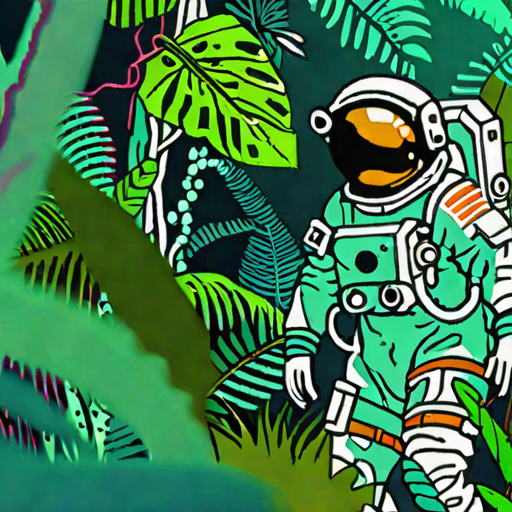

In [1]:
from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained("stabilityai/sdxl-turbo")
pipe = pipe.to("cuda")
prompt = "Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"
image = pipe(prompt).images[0]
image

c:\Users\GGPC\Desktop\Work\Personal Projects\Live Diffusion\sdxl_turbo_venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\GGPC\Desktop\Work\Personal Projects\Live Diffusion\sdxl_turbo_venv\lib\site-packages\diffusers\utils\outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
c:\Users\GGPC\Desktop\Work\Personal Projects\Live Diffusion\sdxl_turbo_venv\lib\site-packages\diffusers\utils\outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
c:\Users\GGPC\Desktop\Work\Personal Projects\Live Diffusion\sdxl_turbo_venv\lib\site-pa

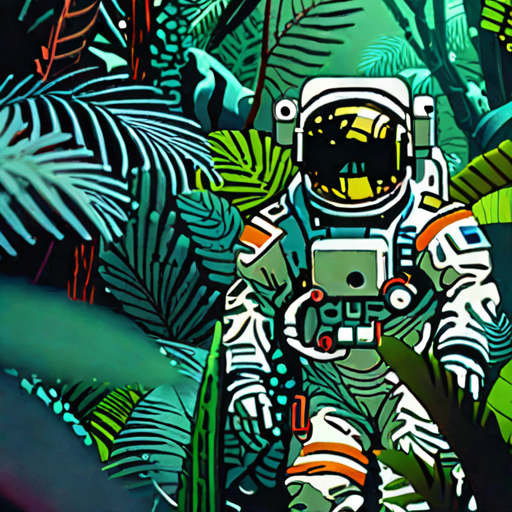

In [1]:
from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained("stabilityai/sdxl-turbo")
pipe = pipe.to("cuda")

prompt = "photorealistic Astronaut in a jungle, cold color palette, muted colors, detailed, 8k"
image = pipe(prompt).images[0]
image

## Controlnet setup draft

### Canny image creation using openCV

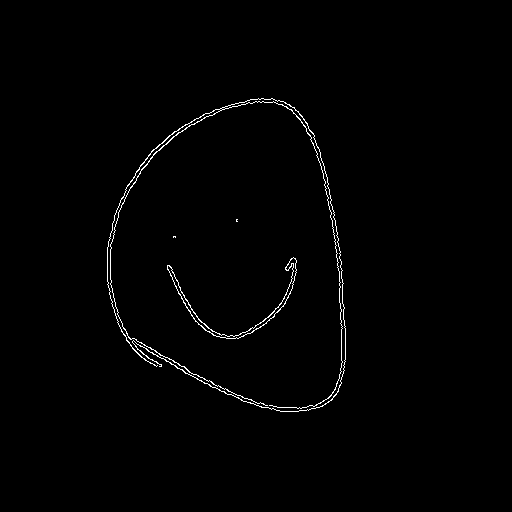

In [7]:
import numpy as np
from PIL import Image
import cv2

low_threshold = 100
high_threshold = 200

# image creation
image = np.array(Image.open("sketch.jpeg"))
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)

canny_image = Image.fromarray(image)
canny_image

### Using PIL to make sketch grayscale

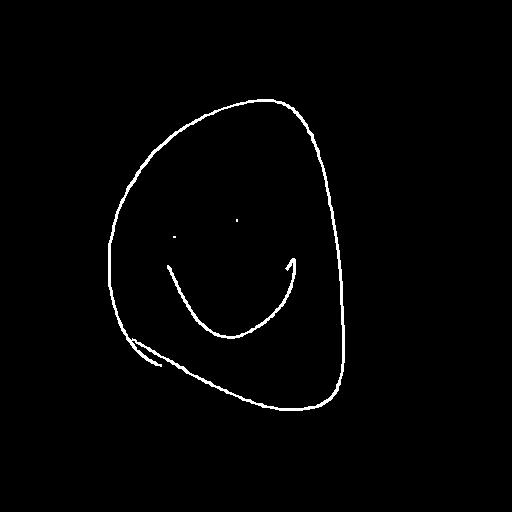

In [4]:
from PIL import Image, ImageFilter, ImageOps

# Load the image
image = Image.open("sketch.jpeg")

# Convert the image to grayscale
gray = image.convert("L")

# Use the ImageOps.grayscale function to create a line art effect
line_art = ImageOps.grayscale(gray)
line_art = ImageOps.invert(line_art)

line_art

# Controlnet Pipeline Testing

In [ ]:
# initiate stable diffusion xl
import numpy as np
import torch
from diffusers import StableDiffusionXLControlNetPipeline, ControlNetModel, AutoencoderKL, DiffusionPipeline, UniPCMultistepScheduler, DDIMScheduler, LCMScheduler
from PIL import Image, ImageFilter, ImageOps
import cv2

# CONFIG
controlnet_model = "xinsir/controlnet-scribble-sdxl-1.0"
# sdxl_model = "SimianLuo/LCM_Dreamshaper_v7"
sdxl_model = "stabilityai/sdxl-turbo"
# lcm_adapter = "latent-consistency/lcm-lora-sdxl"

# Load ControlNet model for sketch conditioning.
# controlnet_conditioning_scale = 0.7 # how strongly to adhere to the control_image
# controlnet = ControlNetModel.from_pretrained(
#     controlnet_model,
#     torch_dtype=torch.float16,
#     use_safetensors=True # model will use 16bit precision (which is half precision) for reduced mem usage and faster computations.
# )

# setup pipeline
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    sdxl_model,
    # controlnet = controlnet,
    torch_dtype=torch.float16,
    use_safetensors=True # model will use 16bit precision (which is half precision) for reduced mem usage and faster computations.
)

# # load LCM adapter
# pipe.load_lora_weights(lcm_adapter)

# pipeline control
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

# Load the image
image = Image.open("sketch4.jpeg")

# Convert the image to grayscale
gray = image.convert("L")

# Use the ImageOps.grayscale function to create a line art effect
line_art = ImageOps.grayscale(gray)
line_art = ImageOps.invert(line_art)

width, height  = line_art.size
ratio = np.sqrt(1024. * 1024. / (width * height))
new_width, new_height = int(width * ratio), int(height * ratio)
line_art = line_art.resize((new_width, new_height))

# VAE
# vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)

# Prompt
prompt = "a photorealistic architectural render of a [intierior of a hotel], featuring [minimalist] design elements in a [interior] environment, realistic lighting, 8K resolution, cinematic atmosphere, masterpiece."
neg_prompt = "cartoon, anime, sketch, line art, stylized illustration, low resolution, disfigured, text, watermark, logo, poorly drawn, overly saturated colors"

# output
images = pipe(
    prompt,
    negative_prompt=neg_prompt,
    image=line_art,                                                 # input image
    # control_image=line_art,                                         # controlnet image
    # controlnet_conditioning_scale=controlnet_conditioning_scale,    # how strongly to adhere to the control_image
    width=new_width,                                                # output width of the image
    height=new_height,                                              # output height of the image
    num_inference_steps=4,                                         # how many times to denoise latent - more = finer detail
    guidance_scale=7,                                               # how strongly to adhere to the prompt
    strength=0.5,                                                   # img2img - how much of the original image to keep
    guess_mode=True,                                                # if True, tries to guss from minimal condition (rough sketches) 
    eta=0.5,                                                        # adds additional noise to the image (high=more variability)
    # vae=vae,                                                        # compresses images and decompresses - for faster inference 
    # num_images_per_prompt=2,                                      # how many images to generate                                             
    ).images[0]

images


# For compatibility check

In [ ]:
from diffusers import AutoPipelineForImage2Image, DiffusionPipeline, DPMSolverMultistepScheduler, StableDiffusionXLControlNetPipeline, ControlNetModel, StableDiffusionUpscalePipeline
from diffusers.utils import load_image, make_image_grid

from PIL import Image, ImageOps
from io import BytesIO
import torch

# CONFIG
controlnet_model = "xinsir/controlnet-scribble-sdxl-1.0"
# sdxl_model = "SimianLuo/LCM_Dreamshaper_v7"
# sdxl_model = "SG161222/RealVisXL_V3.0_Turbo"
sdxl_model = "SG161222/RealVisXL_V4.0_Lightning"
# sdxl_model = "SG161222/RealVisXL_V5.0_Lightning"
# lcm_adapter = "latent-consistency/lcm-lora-sdxl"

# Load ControlNet model for sketch conditioning.
controlnet_conditioning_scale = 0.7                 # how strongly to adhere to the control_image
controlnet = ControlNetModel.from_pretrained(
    controlnet_model,
    torch_dtype=torch.float16,                      # model will use 16bit precision (which is half precision) for reduced mem usage and faster computations.
    use_safetensors=True,
)

# setup pipeline
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    sdxl_model,
    controlnet = controlnet,
    torch_dtype=torch.float16,
    use_safetensors=True,                             # model will use 16bit precision (which is half precision) for reduced mem usage and faster computations.
    variant="fp16"
)

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()


image = Image.open("sketch4.jpeg")

# Convert the image to grayscale
gray = image.convert("L")

# Use the ImageOps.grayscale function to create a line art effect
line_art = ImageOps.grayscale(gray)
line_art = ImageOps.invert(line_art)

input_image = load_image("sketch4.jpeg").resize((512, 512))


prompt = "a photorealistic architectural render of a [intierior of a hotel], featuring [minimalist] design elements in a [interior] environment, realistic lighting, 8K resolution, cinematic atmosphere, masterpiece."
neg_prompt = "cartoon, anime, sketch, line art, stylized illustration, low resolution, disfigured, text, watermark, logo, poorly drawn, overly saturated colors"

low_res_img = pipe(prompt,
             negative_prompt=neg_prompt,
             image=input_image,
             control_image=line_art, 
             num_inference_steps=10, 
             strength=0.5, 
             guidance_scale=5,
             controlnet_conditioning_scale=controlnet_conditioning_scale,
             guess_mode=True,
             eta=0.5
             ).images[0]

# low_res_img = low_res_img.resize((512, 512))
low_res_img

# upscale_model = "stabilityai/stable-diffusion-x4-upscaler"
# upscaler = StableDiffusionUpscalePipeline.from_pretrained(upscale_model, torch_dtype=torch.float16)
# upscaler = upscaler.to("cuda")

# low_res_img = low_res_img.resize((128, 128))

# prompt = "realistic lighting, 8K resolution, cinematic atmosphere, masterpiece."

# upscaled_image = upscaler(prompt=prompt, image=low_res_img, num_inference_steps=30).images[0]
# upscaled_image = upscaled_image.resize((512, 512))
# low_res_img = low_res_img.resize((512, 512))

# make_image_grid([low_res_img, upscaled_image], rows=1, cols=2)


# Upscaler Testing

In [ ]:
import requests
from PIL import Image
from io import BytesIO
from diffusers import StableDiffusionUpscalePipeline
import torch

# load model and scheduler
model_id = "stabilityai/stable-diffusion-x4-upscaler"
pipeline = StableDiffusionUpscalePipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipeline = pipeline.to("cuda")

# let's download an  image
url = "https://huggingface.co/datasets/hf-internal-testing/diffusers-images/resolve/main/sd2-upscale/low_res_cat.png"
response = requests.get(url)
low_res_img = Image.open(BytesIO(response.content)).convert("RGB")
low_res_img
low_res_img = low_res_img.resize((128, 128))

prompt = "a white cat"

upscaled_image = pipeline(prompt=prompt, image=low_res_img).images[0]
upscaled_image.save("upsampled_cat.png")


# Inpaint testing 

In [ ]:
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image
import torch

pipe = AutoPipelineForInpainting.from_pretrained("diffusers/stable-diffusion-xl-1.0-inpainting-0.1", torch_dtype=torch.float16, variant="fp16").to("cuda")

img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

image = load_image(img_url).resize((1024, 1024))
mask_image = load_image(mask_url).resize((1024, 1024))

prompt = "a tiger sitting on a park bench"
generator = torch.Generator(device="cuda").manual_seed(0)

image = pipe(
  prompt=prompt,
  image=image,
  mask_image=mask_image,
  guidance_scale=8.0,
  num_inference_steps=20,  # steps between 15 and 30 work well for us
  strength=0.99,  # make sure to use `strength` below 1.0
  generator=generator,
).images[0]


# Sketch App General Code

In [2]:
import os
import tkinter as tk
from PIL import Image, ImageDraw


class SketchApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Sketch Stage")

        # Canvas dimensions
        self.canvas_width = 1024
        self.canvas_height = 1024

        # Create the tkinter Canvas for sketching
        self.canvas = tk.Canvas(root, width=self.canvas_width, height=self.canvas_height, bg="white")
        self.canvas.pack(padx=10, pady=10)

        # Create a PIL image that will hold the sketch data (white background)
        self.sketch = Image.new("RGB", (self.canvas_width, self.canvas_height), "white")
        self.draw = ImageDraw.Draw(self.sketch)
        
        # create stack of stages for undo
        self.undo_stack = []
        
        self.current_stroke_item_ids = []
        

        # Bind mouse events for drawing
        self.canvas.bind("<ButtonPress-1>", self.on_button_press)
        self.canvas.bind("<B1-Motion>", self.on_mouse_drag)
        self.canvas.bind("<ButtonRelease-1>", self.on_button_release)
        
        # ctrl - z 
        self.root.bind("<Control-z>", self.on_ctrl_z)

        # add a "Clear" button
        self.clear_button = tk.Button(root, text="Clear Canvas", command=self.clear_canvas)
        self.clear_button.pack(pady=5)

        # add a "Save" button
        self.save_button = tk.Button(root, text="Save Sketch", command=self.save_sketch)
        self.save_button.pack(pady=5)
        
        self.last_x, self.last_y = None, None
        

    def on_button_press(self, event):
        # Record the starting position for the line
        self.last_x, self.last_y = event.x, event.y

    def on_mouse_drag(self, event):
        # Get current mouse coordinates
        x, y = event.x, event.y

        # Draw on the canvas (visible to the user)
        line_id = self.canvas.create_line(self.last_x, self.last_y, x, y, fill="black", width=3)
        self.current_stroke_item_ids.append(line_id)

        # Draw on the PIL image (to be used later in your pipeline)
        self.draw.line([self.last_x, self.last_y, x, y], fill="black", width=3)

        # Update the last coordinates
        self.last_x, self.last_y = x, y
        
    def on_button_release(self, event):
        
        if self.current_stroke_item_ids:
            image_copy = self.sketch.copy()
            self.undo_stack.append({'image': image_copy,
                                    'item_ids': self.current_stroke_item_ids})
        self.current_stroke_item_ids = []
        self.last_x, self.last_y = None, None
        
    def on_ctrl_z(self, event):
        print("Ctrl-Z pressed")
        self.undo()

    def undo(self):
        if not self.undo_stack:
            return # Nothing to undo
        
        last_state = self.undo_stack.pop()
        # revert PIL image
        self.sketch = last_state['image']
        # Recreate the draw object
        self.draw = ImageDraw.Draw(self.sketch)
        
        # Remove the stroke's item IDs from the canvas
        for item_id in last_state['item_ids']:
            self.canvas.delete(item_id)

    def clear_canvas(self):
        # Clear the tkinter canvas
        self.canvas.delete("all")
        # Reset the PIL image to a blank white image
        self.sketch = Image.new("RGB", (self.canvas_width, self.canvas_height), "white")
        self.draw = ImageDraw.Draw(self.sketch)
        
    def sketch_save(self, filename):
        self.sketch.save(filename)
        print(f"Sketch saved as '{filename}'")
    
    def save_sketch(self):
        i = 1
        if os.path.exists("sketch.jpeg"):
            # If the file already exists, add a number to the filename
            while os.path.exists(f"sketch{i}.jpeg"):
                i += 1
            filename = f"sketch{i}.jpeg"
        else:
            filename = "sketch.jpeg"
            
        # Save the PIL image to a file
        self.sketch_save(filename)
        print(f"Sketch saved as '{filename}'")
        
        # Optionally, show a message box
        tk.messagebox.showinfo("Sketch Saved", f"Sketch saved as '{filename}'")

# To test app
if __name__ == "__main__":
    root = tk.Tk()
    app = SketchApp(root)
    root.mainloop()


# Inference on Button Release

In [ ]:
import threading
import tkinter as tk
from tkinter import messagebox, filedialog
from PIL import Image, ImageDraw, ImageOps, ImageTk
import numpy as np
import torch

# Diffusers imports
from diffusers import (
    AutoPipelineForImage2Image,
    DiffusionPipeline,
    DPMSolverMultistepScheduler,
    StableDiffusionXLControlNetPipeline,
    ControlNetModel,
    StableDiffusionUpscalePipeline,
)
from diffusers.utils import load_image, make_image_grid

##############################################
# Global Pipeline Initialization and Configs
##############################################

# CONFIG
controlnet_model = "xinsir/controlnet-scribble-sdxl-1.0"
sdxl_model = "SG161222/RealVisXL_V4.0_Lightning"
controlnet_conditioning_scale = 0.7  # How strongly to adhere to the control image

# Load the ControlNet model (using FP16 precision)
controlnet = ControlNetModel.from_pretrained(
    controlnet_model,
    torch_dtype=torch.float16,
    use_safetensors=True,
)

# Load the main SDXL pipeline with ControlNet attached
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    sdxl_model,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

# Load the upscaler pipeline once and move to CUDA
upscale_model = "stabilityai/stable-diffusion-x4-upscaler"
upscaler = StableDiffusionUpscalePipeline.from_pretrained(
    upscale_model, torch_dtype=torch.float16
)
upscaler = upscaler.to("cuda")

##############################################
# Inference Helper Functions
##############################################

def generate_preview_image(sketch_image):
    """
    Generate a preview (low-resolution) image from the sketch.
    The sketch is used to create both:
      - an input image (resized to 512x512)
      - a control image (converted to grayscale and inverted)
    """
    # Create the input image (resize to 512x512)
    input_image = sketch_image.resize((512, 512))
    # Create the control image (line art effect)
    control_image = ImageOps.invert(ImageOps.grayscale(sketch_image))
    
    # Prompts
    prompt = ("a photorealistic architectural render of a [intierior of a hotel], featuring "
              "[minimalist] design elements in a [interior] environment, realistic lighting, "
              "8K resolution, cinematic atmosphere, masterpiece.")
    neg_prompt = ("cartoon, anime, sketch, line art, stylized illustration, low resolution, disfigured, "
                  "text, watermark, logo, poorly drawn, overly saturated colors")
    
    # Run the ControlNet pipeline
    low_res_img = pipe(
        prompt,
        negative_prompt=neg_prompt,
        image=input_image,
        control_image=control_image,
        num_inference_steps=8,
        strength=0.5,
        guidance_scale=5,
        controlnet_conditioning_scale=controlnet_conditioning_scale,
        guess_mode=True,
        eta=0.5
    ).images[0]
    
    # Ensure output is 512x512 for preview
    low_res_img = low_res_img.resize((512, 512))
    return low_res_img

def generate_high_res_image(sketch_image):
    """
    Generate a high-resolution output by first generating a low-res image and then upscaling it.
    The low-res image is resized to 128x128 before upscaling.
    """
    # Generate the low-resolution image first
    low_res_img = generate_preview_image(sketch_image)
    
    # Resize for upscaling (simulate lower resolution input to the upscaler)
    low_res_small = low_res_img.resize((128, 128))
    
    upscale_prompt = "realistic lighting, 8K resolution, cinematic atmosphere, masterpiece."
    upscaled_image = upscaler(
        prompt=upscale_prompt,
        image=low_res_small,
        num_inference_steps=30
    ).images[0]
    
    # Resize upscaled output to standard 512x512 dimensions
    upscaled_image = upscaled_image.resize((512, 512))
    return upscaled_image

##############################################
# Sketch Application with Inference & UI
##############################################

class SketchApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Sketch-to-Image Inference")
        
        # Set up the sketch canvas
        self.canvas_width = 512
        self.canvas_height = 512
        self.canvas = tk.Canvas(root, width=self.canvas_width, height=self.canvas_height, bg="white")
        self.canvas.grid(row=0, column=0, padx=10, pady=10, rowspan=6)
        
        # Bind mouse motion to update the eraser cursor preview
        self.canvas.bind("<Motion>", self.update_cursor_circle)
        self.eraser_cursor_id = None  # to store the id of the eraser preview circle
        
        # PIL image for drawing (the sketch)
        self.sketch = Image.new("RGB", (self.canvas_width, self.canvas_height), "white")
        self.draw = ImageDraw.Draw(self.sketch)
        self.undo_stack = []
        self.current_stroke_item_ids = []
        
        # Default drawing settings
        self.current_color = "black"  # "black" for drawing, "white" for erasing
        self.brush_width = 3
        
        # Bind mouse events for drawing
        self.canvas.bind("<ButtonPress-1>", self.on_button_press)
        self.canvas.bind("<B1-Motion>", self.on_mouse_drag)
        self.canvas.bind("<ButtonRelease-1>", self.on_button_release)
        self.root.bind("<Control-z>", self.on_ctrl_z)
        
        # Label for displaying the generated image preview
        self.output_label = tk.Label(root)
        self.output_label.grid(row=0, column=1, padx=10, pady=10, rowspan=4)
        
        # Buttons for additional functions
        self.clear_button = tk.Button(root, text="Clear Canvas", command=self.clear_canvas)
        self.clear_button.grid(row=4, column=1, padx=10, pady=5, sticky="ew")
        
        self.eraser_button = tk.Button(root, text="Toggle Eraser", command=self.toggle_eraser)
        self.eraser_button.grid(row=5, column=1, padx=10, pady=5, sticky="ew")
        
        self.save_button = tk.Button(root, text="Save Generated", command=self.save_generated)
        self.save_button.grid(row=6, column=1, padx=10, pady=5, sticky="ew")
        
        self.high_res_button = tk.Button(root, text="High Res Render", command=self.trigger_high_res_inference)
        self.high_res_button.grid(row=6, column=0, padx=10, pady=5, sticky="ew")
        
        self.start_inference_button = tk.Button(root, text="Start Inference", command=self.start_inference_loop)
        self.start_inference_button.grid(row=7, column=0, padx=10, pady=5, sticky="ew")
        
        self.stop_inference_button = tk.Button(root, text="Stop Inference", command=self.stop_inference_loop)
        self.stop_inference_button.grid(row=7, column=1, padx=10, pady=5, sticky="ew")
        
        # New Upscaling Toggle Button
        self.upscaling_enabled = False
        self.upscale_toggle_button = tk.Button(root, text="Upscaling: Off", command=self.toggle_upscaling)
        self.upscale_toggle_button.grid(row=8, column=0, columnspan=2, padx=10, pady=5, sticky="ew")
        
        # Brush size control slider
        self.brush_size_scale = tk.Scale(root, from_=1, to=50, orient=tk.HORIZONTAL,
                                         label="Brush/Eraser Size", command=self.update_brush_size)
        self.brush_size_scale.set(self.brush_width)
        self.brush_size_scale.grid(row=9, column=0, columnspan=2, padx=10, pady=5, sticky="ew")
        
        # Set up consistent background preview inference (every 5 seconds)
        self.update_interval_ms = 5000
        self.is_inference_running = False
        self.generated_image = None  # holds the last preview result
        self.inference_active = True   # flag controlling whether inference is scheduled
        self.inference_job_id = None   # will store the job ID for cancellation
        self.schedule_inference()
        
        # Variables to hold drawing coordinates
        self.last_x, self.last_y = None, None

    def on_button_press(self, event):
        self.last_x, self.last_y = event.x, event.y

    def on_mouse_drag(self, event):
        x, y = event.x, event.y
        # Remove the eraser preview while drawing
        if self.eraser_cursor_id is not None:
            self.canvas.delete(self.eraser_cursor_id)
            self.eraser_cursor_id = None
        # Draw a line on the canvas for visual feedback
        line_id = self.canvas.create_line(self.last_x, self.last_y, x, y, fill=self.current_color, width=self.brush_width)
        self.current_stroke_item_ids.append(line_id)
        # Draw on the underlying PIL sketch
        self.draw.line([self.last_x, self.last_y, x, y], fill=self.current_color, width=self.brush_width)
        self.last_x, self.last_y = x, y

    def on_button_release(self, event):
        # Save stroke for undo functionality
        if self.current_stroke_item_ids:
            image_copy = self.sketch.copy()
            self.undo_stack.append({'image': image_copy, 'item_ids': self.current_stroke_item_ids})
        self.current_stroke_item_ids = []
        self.last_x, self.last_y = None, None

    def on_ctrl_z(self, event):
        if self.undo_stack:
            last_state = self.undo_stack.pop()
            self.sketch = last_state['image']
            self.draw = ImageDraw.Draw(self.sketch)
            for item_id in last_state['item_ids']:
                self.canvas.delete(item_id)

    def update_cursor_circle(self, event):
        """Show a preview circle for the eraser radius when in eraser mode."""
        if self.current_color == "white":
            # Calculate circle coordinates
            radius = self.brush_width // 2
            x1 = event.x - radius
            y1 = event.y - radius
            x2 = event.x + radius
            y2 = event.y + radius
            # If already exists, update; otherwise, create a new circle with a dashed outline
            if self.eraser_cursor_id is None:
                self.eraser_cursor_id = self.canvas.create_oval(x1, y1, x2, y2, outline="red", dash=(2,2))
            else:
                self.canvas.coords(self.eraser_cursor_id, x1, y1, x2, y2)
        else:
            # Not in eraser mode: remove the cursor circle if present
            if self.eraser_cursor_id is not None:
                self.canvas.delete(self.eraser_cursor_id)
                self.eraser_cursor_id = None

    def update_brush_size(self, value):
        """Update the brush/eraser size based on slider value."""
        self.brush_width = int(value)
        # Update eraser cursor circle if active
        # (force update by simulating a motion event if needed)
    
    def schedule_inference(self):
        """Schedule the next preview inference run if inference is active."""
        if self.inference_active:
            self.inference_job_id = self.root.after(self.update_interval_ms, self.start_inference_thread)

    def start_inference_thread(self):
        """Launch preview inference in a background thread if not already running."""
        if not self.is_inference_running:
            self.is_inference_running = True
            thread = threading.Thread(target=self.run_inference)
            thread.start()
        if self.inference_active:
            self.schedule_inference()

    def run_inference(self):
        """Run generation (low-res or high-res based on upscale toggle) and update the output."""
        try:
            if self.upscaling_enabled:
                result_img = generate_high_res_image(self.sketch)
            else:
                result_img = generate_preview_image(self.sketch)
            self.generated_image = result_img
            self.root.after(0, self.update_output, result_img)
        except Exception as e:
            print("Error during preview inference:", e)
        finally:
            self.is_inference_running = False

    def trigger_high_res_inference(self):
        """Force a high-resolution generation in a background thread."""
        thread = threading.Thread(target=self.run_high_res_inference)
        thread.start()

    def run_high_res_inference(self):
        """Run high-res generation (low-res + upscaling) and update the output label."""
        try:
            high_res_img = generate_high_res_image(self.sketch)
            self.generated_image = high_res_img
            self.root.after(0, self.update_output, high_res_img)
        except Exception as e:
            print("Error during high-res inference:", e)

    def update_output(self, img):
        """Update the output label with the provided image."""
        self.generated_tk_img = ImageTk.PhotoImage(img)
        self.output_label.config(image=self.generated_tk_img)

    def clear_canvas(self):
        """Clear the sketch canvas and reset the underlying image."""
        self.canvas.delete("all")
        self.sketch = Image.new("RGB", (self.canvas_width, self.canvas_height), "white")
        self.draw = ImageDraw.Draw(self.sketch)
        self.undo_stack.clear()
        self.output_label.config(image="")

    def toggle_eraser(self):
        """Toggle between drawing and erasing."""
        if self.current_color == "black":
            self.current_color = "white"
            self.eraser_button.config(text="Toggle Draw")
        else:
            self.current_color = "black"
            self.eraser_button.config(text="Toggle Eraser")
            # Remove the eraser preview if switching to draw mode
            if self.eraser_cursor_id is not None:
                self.canvas.delete(self.eraser_cursor_id)
                self.eraser_cursor_id = None

    def save_generated(self):
        """Save the currently generated image to disk."""
        if self.generated_image is None:
            messagebox.showwarning("No Image", "No generated image to save yet!")
            return
        file_path = filedialog.asksaveasfilename(
            defaultextension=".jpeg",
            filetypes=[("JPEG files", "*.jpeg"), ("PNG files", "*.png"), ("All files", "*.*")]
        )
        if file_path:
            try:
                self.generated_image.save(file_path)
                messagebox.showinfo("Image Saved", f"Generated image saved as:\n{file_path}")
            except Exception as e:
                messagebox.showerror("Save Error", f"Failed to save image:\n{e}")

    def start_inference_loop(self):
        """Start the scheduled preview inference loop."""
        self.inference_active = True
        self.schedule_inference()

    def stop_inference_loop(self):
        """Stop the scheduled preview inference loop."""
        self.inference_active = False
        if self.inference_job_id is not None:
            self.root.after_cancel(self.inference_job_id)
            self.inference_job_id = None

    def toggle_upscaling(self):
        """Toggle the upscaling mode on and off and update the button label."""
        self.upscaling_enabled = not self.upscaling_enabled
        if self.upscaling_enabled:
            self.upscale_toggle_button.config(text="Upscaling: On")
        else:
            self.upscale_toggle_button.config(text="Upscaling: Off")

##############################################
# Run the Application
##############################################

if __name__ == "__main__":
    root = tk.Tk()
    app = SketchApp(root)
    root.mainloop()


# Low Res Inference with Upscaling (Test Draft)

In [ ]:
import threading
import tkinter as tk
from tkinter import messagebox, filedialog
from PIL import Image, ImageDraw, ImageOps, ImageTk
import numpy as np
import torch

# Diffusers imports
from diffusers import (
    AutoPipelineForImage2Image,
    DiffusionPipeline,
    DPMSolverMultistepScheduler,
    StableDiffusionXLControlNetPipeline,
    ControlNetModel,
    StableDiffusionUpscalePipeline,
)
from diffusers.utils import load_image, make_image_grid

##############################################
# Global Pipeline Initialization and Configs
##############################################

# CONFIG
controlnet_model = "xinsir/controlnet-scribble-sdxl-1.0"
sdxl_model = "SG161222/RealVisXL_V4.0_Lightning"
controlnet_conditioning_scale = 0.7  # How strongly to adhere to the control image

# Load the ControlNet model (using FP16 precision)
controlnet = ControlNetModel.from_pretrained(
    controlnet_model,
    torch_dtype=torch.float16,
    use_safetensors=True,
)

# Load the main SDXL pipeline with ControlNet attached
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    sdxl_model,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

# Load the upscaler pipeline once and move to CUDA
upscale_model = "stabilityai/stable-diffusion-x4-upscaler"
upscaler = StableDiffusionUpscalePipeline.from_pretrained(
    upscale_model, torch_dtype=torch.float16
)
upscaler = upscaler.to("cuda")

##############################################
# Inference Helper Functions
##############################################

def generate_preview_image(sketch_image):
    """
    Generate a preview (low-resolution) image from the sketch.
    The sketch is used to create both:
      - an input image (resized to 512x512)
      - a control image (converted to grayscale and inverted)
    """
    # Create the input image (resize to 512x512)
    input_image = sketch_image.resize((512, 512))
    # Create the control image (line art effect)
    control_image = ImageOps.invert(ImageOps.grayscale(sketch_image))
    
    # Prompts
    prompt = ("a photorealistic architectural render of a [interior of a hotel], featuring "
              "[minimalist] design elements in a [interior] environment, realistic lighting, "
              "8K resolution, cinematic atmosphere, masterpiece.")
    neg_prompt = ("cartoon, anime, sketch, line art, stylized illustration, low resolution, disfigured, "
                  "text, watermark, logo, poorly drawn, overly saturated colors")
    
    # Run the ControlNet pipeline
    low_res_img = pipe(
        prompt,
        negative_prompt=neg_prompt,
        image=input_image,
        control_image=control_image,
        num_inference_steps=8,
        strength=0.5,
        guidance_scale=5,
        controlnet_conditioning_scale=controlnet_conditioning_scale,
        guess_mode=True,
        eta=0.5
    ).images[0]
    
    # Ensure output is 512x512 for preview
    low_res_img = low_res_img.resize((512, 512))
    return low_res_img

def generate_high_res_image(sketch_image):
    """
    Generate a high-resolution output by first generating a low-res image and then upscaling it.
    The low-res image is resized to 128x128 before upscaling.
    """
    # Generate the low-resolution image first
    low_res_img = generate_preview_image(sketch_image)
    
    # Resize for upscaling (simulate lower resolution input to the upscaler)
    low_res_small = low_res_img.resize((128, 128))
    
    upscale_prompt = "realistic lighting, 8K resolution, cinematic atmosphere, masterpiece."
    upscaled_image = upscaler(
        prompt=upscale_prompt,
        image=low_res_small,
        num_inference_steps=30
    ).images[0]
    
    # Resize upscaled output to standard 512x512 dimensions
    upscaled_image = upscaled_image.resize((512, 512))
    return upscaled_image

##############################################
# Sketch Application with Inference, Inpainting & UI
##############################################

class SketchApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Sketch-to-Image Inference")
        
        # Set up the sketch canvas
        self.canvas_width = 512
        self.canvas_height = 512
        self.canvas = tk.Canvas(root, width=self.canvas_width, height=self.canvas_height, bg="white")
        self.canvas.grid(row=0, column=0, padx=10, pady=10, rowspan=6)
        
        # Bind mouse motion to update the eraser cursor preview
        self.canvas.bind("<Motion>", self.update_cursor_circle)
        self.eraser_cursor_id = None  # to store the id of the eraser preview circle
        
        # PIL image for drawing (the sketch)
        self.sketch = Image.new("RGB", (self.canvas_width, self.canvas_height), "white")
        self.draw = ImageDraw.Draw(self.sketch)
        self.undo_stack = []
        self.current_stroke_item_ids = []
        
        # Inpainting mode attributes
        self.inpainting_mode = False
        self.inpaint_mask = None   # a "L" mode image: 0 means no mask, 255 means mask applied
        self.base_for_inpainting = None  # base image for inpainting
        
        # Default drawing settings
        self.current_color = "black"  # In normal mode: black draws, white erases.
                                     # In inpainting mode: "red" adds mask, "black" erases mask.
        self.brush_width = 3
        
        # Bind mouse events for drawing
        self.canvas.bind("<ButtonPress-1>", self.on_button_press)
        self.canvas.bind("<B1-Motion>", self.on_mouse_drag)
        self.canvas.bind("<ButtonRelease-1>", self.on_button_release)
        self.root.bind("<Control-z>", self.on_ctrl_z)
        
        # Label for displaying the generated image preview
        self.output_label = tk.Label(root)
        self.output_label.grid(row=0, column=1, padx=10, pady=10, rowspan=4)
        
        # Buttons for additional functions
        self.clear_button = tk.Button(root, text="Clear Canvas", command=self.clear_canvas)
        self.clear_button.grid(row=4, column=1, padx=10, pady=5, sticky="ew")
        
        self.eraser_button = tk.Button(root, text="Toggle Eraser", command=self.toggle_eraser)
        self.eraser_button.grid(row=5, column=1, padx=10, pady=5, sticky="ew")
        
        # New button to toggle inpainting mode
        self.toggle_inpaint_mode_button = tk.Button(root, text="Enter Inpainting Mode", command=self.toggle_inpainting_mode)
        self.toggle_inpaint_mode_button.grid(row=6, column=1, padx=10, pady=5, sticky="ew")
        
        self.save_button = tk.Button(root, text="Save Generated", command=self.save_generated)
        self.save_button.grid(row=7, column=1, padx=10, pady=5, sticky="ew")
        
        self.high_res_button = tk.Button(root, text="High Res Render", command=self.trigger_high_res_inference)
        self.high_res_button.grid(row=7, column=0, padx=10, pady=5, sticky="ew")
        
        self.start_inference_button = tk.Button(root, text="Start Inference", command=self.start_inference_loop)
        self.start_inference_button.grid(row=8, column=0, padx=10, pady=5, sticky="ew")
        
        self.stop_inference_button = tk.Button(root, text="Stop Inference", command=self.stop_inference_loop)
        self.stop_inference_button.grid(row=8, column=1, padx=10, pady=5, sticky="ew")
        
        # New Upscaling Toggle Button
        self.upscaling_enabled = False
        self.upscale_toggle_button = tk.Button(root, text="Upscaling: Off", command=self.toggle_upscaling)
        self.upscale_toggle_button.grid(row=9, column=0, columnspan=2, padx=10, pady=5, sticky="ew")
        
        # Brush size control slider
        self.brush_size_scale = tk.Scale(root, from_=1, to=50, orient=tk.HORIZONTAL,
                                         label="Brush/Eraser Size", command=self.update_brush_size)
        self.brush_size_scale.set(self.brush_width)
        self.brush_size_scale.grid(row=10, column=0, columnspan=2, padx=10, pady=5, sticky="ew")
        
        # Set up consistent background preview inference (every 5 seconds)
        self.update_interval_ms = 5000
        self.is_inference_running = False
        self.generated_image = None  # holds the last preview result
        self.inference_active = True   # flag controlling whether inference is scheduled
        self.inference_job_id = None   # will store the job ID for cancellation
        self.schedule_inference()
        
        # Variables to hold drawing coordinates
        self.last_x, self.last_y = None, None

    def on_button_press(self, event):
        self.last_x, self.last_y = event.x, event.y

        # In inpainting mode, if starting a new stroke, initialize the mask if needed.
        if self.inpainting_mode and self.inpaint_mask is None:
            self.inpaint_mask = Image.new("L", (self.canvas_width, self.canvas_height), 0)

    def on_mouse_drag(self, event):
        x, y = event.x, event.y
        # Remove the eraser preview while drawing
        if self.eraser_cursor_id is not None:
            self.canvas.delete(self.eraser_cursor_id)
            self.eraser_cursor_id = None

        # If in inpainting mode, update the mask rather than the sketch.
        if self.inpainting_mode:
            # Draw a line on the canvas for visual feedback.
            line_id = self.canvas.create_line(
                self.last_x, self.last_y, x, y,
                fill=self.current_color,
                width=self.brush_width,
                capstyle=tk.ROUND,
                smooth=True,
                splinesteps=36
            )
            self.current_stroke_item_ids.append(line_id)

            # Map the current color to a mask value:
            # "red" means add mask (255) and "black" means remove mask (0)
            mask_val = 255 if self.current_color == "red" else 0
            mask_draw = ImageDraw.Draw(self.inpaint_mask)
            mask_draw.line([self.last_x, self.last_y, x, y],
                           fill=mask_val,
                           width=self.brush_width)
            # Draw an ellipse for smoother edges
            mask_draw.ellipse(
                (x - self.brush_width//2, y - self.brush_width//2,
                 x + self.brush_width//2, y + self.brush_width//2),
                fill=mask_val
            )
        else:
            # Normal drawing mode
            line_id = self.canvas.create_line(
                self.last_x, self.last_y, x, y,
                fill=self.current_color,
                width=self.brush_width
            )
            self.current_stroke_item_ids.append(line_id)
            self.draw.line([self.last_x, self.last_y, x, y], fill=self.current_color, width=self.brush_width)
        self.last_x, self.last_y = x, y

    def on_button_release(self, event):
        # Save stroke for undo functionality in normal mode.
        if not self.inpainting_mode and self.current_stroke_item_ids:
            image_copy = self.sketch.copy()
            self.undo_stack.append({'image': image_copy, 'item_ids': self.current_stroke_item_ids})
        self.current_stroke_item_ids = []
        self.last_x, self.last_y = None, None

    def on_ctrl_z(self, event):
        if not self.inpainting_mode and self.undo_stack:
            last_state = self.undo_stack.pop()
            self.sketch = last_state['image']
            self.draw = ImageDraw.Draw(self.sketch)
            for item_id in last_state['item_ids']:
                self.canvas.delete(item_id)

    def update_cursor_circle(self, event):
        """Show a preview circle for the brush size at the cursor."""
        radius = self.brush_width // 2
        x1 = event.x - radius
        y1 = event.y - radius
        x2 = event.x + radius
        y2 = event.y + radius
        # In inpainting mode, use red for "add mask" and black for "erase mask".
        if self.inpainting_mode:
            outline_color = "red" if self.current_color == "red" else "black"
        else:
            outline_color = "red" if self.current_color == "white" else "gray"
        if self.eraser_cursor_id is None:
            self.eraser_cursor_id = self.canvas.create_oval(x1, y1, x2, y2, outline=outline_color, dash=(2,2))
        else:
            self.canvas.coords(self.eraser_cursor_id, x1, y1, x2, y2)
            self.canvas.itemconfig(self.eraser_cursor_id, outline=outline_color)

    def update_brush_size(self, value):
        self.brush_width = int(value)

    def schedule_inference(self):
        """Schedule the next preview inference run if inference is active."""
        if self.inference_active:
            self.inference_job_id = self.root.after(self.update_interval_ms, self.start_inference_thread)

    def start_inference_thread(self):
        """Launch preview inference in a background thread if not already running."""
        if not self.is_inference_running:
            self.is_inference_running = True
            thread = threading.Thread(target=self.run_inference)
            thread.start()
        if self.inference_active:
            self.schedule_inference()

    def run_inference(self):
        """Run generation (low-res or high-res based on upscale toggle) and update the output."""
        try:
            if self.upscaling_enabled:
                result_img = generate_high_res_image(self.sketch)
            else:
                result_img = generate_preview_image(self.sketch)
            self.generated_image = result_img
            self.root.after(0, self.update_output, result_img)
        except Exception as e:
            print("Error during preview inference:", e)
        finally:
            self.is_inference_running = False

    def trigger_high_res_inference(self):
        thread = threading.Thread(target=self.run_high_res_inference)
        thread.start()

    def run_high_res_inference(self):
        try:
            high_res_img = generate_high_res_image(self.sketch)
            self.generated_image = high_res_img
            self.root.after(0, self.update_output, high_res_img)
        except Exception as e:
            print("Error during high-res inference:", e)

    def update_output(self, img):
        self.generated_tk_img = ImageTk.PhotoImage(img)
        self.output_label.config(image=self.generated_tk_img)

    def clear_canvas(self):
        self.canvas.delete("all")
        self.sketch = Image.new("RGB", (self.canvas_width, self.canvas_height), "white")
        self.draw = ImageDraw.Draw(self.sketch)
        self.undo_stack.clear()
        self.output_label.config(image="")
        # Also clear inpainting mask if in inpainting mode.
        if self.inpainting_mode:
            self.inpaint_mask = Image.new("L", (self.canvas_width, self.canvas_height), 0)

    def toggle_eraser(self):
        """
        Toggle between drawing and erasing.
        In normal mode, eraser means drawing in white.
        In inpainting mode, toggling eraser switches between adding mask (red) and erasing mask (black).
        """
        if self.inpainting_mode:
            if self.current_color == "red":
                self.current_color = "black"
                self.eraser_button.config(text="Erase Mask")
            else:
                self.current_color = "red"
                self.eraser_button.config(text="Add Mask")
        else:
            if self.current_color == "black":
                self.current_color = "white"
                self.eraser_button.config(text="Toggle Draw")
            else:
                self.current_color = "black"
                self.eraser_button.config(text="Toggle Eraser")
                if self.eraser_cursor_id is not None:
                    self.canvas.delete(self.eraser_cursor_id)
                    self.eraser_cursor_id = None

    def toggle_inpainting_mode(self):
        """
        Toggle between normal sketch mode and inpainting mode.
        When entering inpainting mode, use the current generated image as the base for inpainting
        and initialize an empty mask. In inpainting mode, drawing will update the mask.
        """
        if not self.inpainting_mode:
            if self.generated_image is None:
                messagebox.showwarning("No Base Image", "No generated image available for inpainting!")
                return
            self.inpainting_mode = True
            self.base_for_inpainting = self.generated_image.copy()
            self.inpaint_mask = Image.new("L", (self.canvas_width, self.canvas_height), 0)
            # Clear canvas and display the base image as the background
            self.canvas.delete("all")
            self.tk_base_img = ImageTk.PhotoImage(self.base_for_inpainting)
            self.canvas.create_image(0, 0, anchor="nw", image=self.tk_base_img)
            # Set default inpainting drawing color to red (to add mask)
            self.current_color = "red"
            self.toggle_inpaint_mode_button.config(text="Exit Inpainting Mode")
            self.eraser_button.config(text="Add Mask")
        else:
            self.inpainting_mode = False
            self.inpaint_mask = None
            self.canvas.delete("all")
            self.current_color = "black"
            self.toggle_inpaint_mode_button.config(text="Enter Inpainting Mode")
            self.eraser_button.config(text="Toggle Eraser")

    def save_generated(self):
        if self.generated_image is None:
            messagebox.showwarning("No Image", "No generated image to save yet!")
            return
        file_path = filedialog.asksaveasfilename(
            defaultextension=".jpeg",
            filetypes=[("JPEG files", "*.jpeg"), ("PNG files", "*.png"), ("All files", "*.*")]
        )
        if file_path:
            try:
                self.generated_image.save(file_path)
                messagebox.showinfo("Image Saved", f"Generated image saved as:\n{file_path}")
            except Exception as e:
                messagebox.showerror("Save Error", f"Failed to save image:\n{e}")

    def start_inference_loop(self):
        self.inference_active = True
        self.schedule_inference()

    def stop_inference_loop(self):
        self.inference_active = False
        if self.inference_job_id is not None:
            self.root.after_cancel(self.inference_job_id)
            self.inference_job_id = None

    def toggle_upscaling(self):
        self.upscaling_enabled = not self.upscaling_enabled
        if self.upscaling_enabled:
            self.upscale_toggle_button.config(text="Upscaling: On")
        else:
            self.upscale_toggle_button.config(text="Upscaling: Off")

##############################################
# Run the Application
##############################################

if __name__ == "__main__":
    root = tk.Tk()
    app = SketchApp(root)
    root.mainloop()


## Consistant Inference (Darft Testing)

In [2]:
import threading
import tkinter as tk
from tkinter import messagebox, filedialog
from PIL import Image, ImageDraw, ImageOps, ImageTk
import numpy as np
import torch
from diffusers import StableDiffusionXLControlNetPipeline, ControlNetModel, AutoencoderKL, DDIMScheduler

# ----------------------------
# Global Model Initialization
# ----------------------------
controlnet_model = "xinsir/controlnet-scribble-sdxl-1.0"
# sdxl_model = "SG161222/RealVisXL_V4.0_Lightning"
sdxl_model = "SimianLuo/LCM_Dreamshaper_v7"
controlnet_conditioning_scale = 0.7

# Load the ControlNet model using FP16 precision
controlnet = ControlNetModel.from_pretrained(
    controlnet_model,
    torch_dtype=torch.float16,
    use_safetensors=True
)

# Load the main SDXL pipeline with ControlNet attached
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    sdxl_model,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    use_safetensors=True
)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

# Load the VAE for faster inference
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)

# ----------------------------
# Inference Functions with Dynamic Resolution Scaling
# ----------------------------
def generate_from_sketch(sketch_image, target_area=1024*1024):
    """
    Preprocess the sketch (convert to grayscale, invert, and resize) using the provided target_area.
    Then run the diffusion pipeline.
    """
    # Convert to grayscale and invert (line-art effect)
    gray = sketch_image.convert("L")
    line_art = ImageOps.grayscale(gray)
    line_art = ImageOps.invert(line_art)
    
    # Efficiently resize image:
    width, height = line_art.size
    # Compute a scaling ratio such that width*height*ratio^2 = target_area
    ratio = np.sqrt(target_area / (width * height))
    new_width, new_height = int(width * ratio), int(height * ratio)
    line_art = line_art.resize((new_width, new_height))
    
    # Define text prompts
    prompt = ("a photorealistic architectural render of a hotel interior, featuring minimalist design elements, "
              "realistic lighting, 8K resolution, cinematic atmosphere, masterpiece.")
    neg_prompt = ("cartoon, anime, sketch, line art, stylized illustration, low resolution, disfigured, text, watermark, "
                  "logo, poorly drawn")
    
    # Run the diffusion pipeline (img2img with ControlNet conditioning)
    result = pipe(
        prompt,
        negative_prompt=neg_prompt,
        image=line_art,                # input image for img2img
        control_image=line_art,        # control image for ControlNet conditioning
        controlnet_conditioning_scale=controlnet_conditioning_scale,
        width=new_width,
        height=new_height,
        num_inference_steps=20,
        guidance_scale=3,
        strength=0.5,
        guess_mode=True,
        eta=0.5,
        vae=vae
    ).images[0]
    
    return result

def generate_from_sketch_preview(sketch_image):
    # Preview target: lower resolution (e.g., 512x512 equivalent)
    return generate_from_sketch(sketch_image, target_area=512*512)

def generate_from_sketch_high_res(sketch_image):
    # High resolution render (e.g., 1024x1024 equivalent)
    return generate_from_sketch(sketch_image, target_area=1024*1024)

# ----------------------------
# Sketch Application with Consistent Background Inference
# ----------------------------
class SketchApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Sketch-to-Image Inference")
        
        # Canvas for drawing (sketch)
        self.canvas_width = 512
        self.canvas_height = 512
        self.canvas = tk.Canvas(root, width=self.canvas_width, height=self.canvas_height, bg="white")
        self.canvas.grid(row=0, column=0, padx=10, pady=10, rowspan=6)
        
        # PIL image for the sketch (used for inference)
        self.sketch = Image.new("RGB", (self.canvas_width, self.canvas_height), "white")
        self.draw = ImageDraw.Draw(self.sketch)
        self.undo_stack = []
        self.current_stroke_item_ids = []
        
        # Default drawing settings
        self.current_color = "black"  # "black" for drawing, "white" for erasing
        self.brush_width = 3
        
        # Bind mouse events for drawing
        self.canvas.bind("<ButtonPress-1>", self.on_button_press)
        self.canvas.bind("<B1-Motion>", self.on_mouse_drag)
        self.canvas.bind("<ButtonRelease-1>", self.on_button_release)
        self.root.bind("<Control-z>", self.on_ctrl_z)
        
        # Label for displaying the generated output image (preview)
        self.output_label = tk.Label(root)
        self.output_label.grid(row=0, column=1, padx=10, pady=10, rowspan=4)
        
        # Buttons for additional functionality
        self.clear_button = tk.Button(root, text="Clear Canvas", command=self.clear_canvas)
        self.clear_button.grid(row=4, column=1, padx=10, pady=5, sticky="ew")
        
        self.eraser_button = tk.Button(root, text="Toggle Eraser", command=self.toggle_eraser)
        self.eraser_button.grid(row=5, column=1, padx=10, pady=5, sticky="ew")
        
        self.save_button = tk.Button(root, text="Save Generated", command=self.save_generated)
        self.save_button.grid(row=6, column=1, padx=10, pady=5, sticky="ew")
        
        self.high_res_button = tk.Button(root, text="High Res Render", command=self.trigger_high_res_inference)
        self.high_res_button.grid(row=6, column=0, padx=10, pady=5, sticky="ew")
        
        # Consistent background inference using a scheduled loop
        self.update_interval_ms = 5000  # run preview inference every 5 seconds
        self.is_inference_running = False
        self.generated_image = None  # last preview result
        self.schedule_inference()
        
        # Coordinates for drawing
        self.last_x, self.last_y = None, None

    def on_button_press(self, event):
        self.last_x, self.last_y = event.x, event.y

    def on_mouse_drag(self, event):
        x, y = event.x, event.y
        # Draw on the canvas for immediate feedback
        line_id = self.canvas.create_line(self.last_x, self.last_y, x, y, fill=self.current_color, width=self.brush_width)
        self.current_stroke_item_ids.append(line_id)
        # Draw on the underlying PIL image
        self.draw.line([self.last_x, self.last_y, x, y], fill=self.current_color, width=self.brush_width)
        self.last_x, self.last_y = x, y

    def on_button_release(self, event):
        # Save the current stroke to allow undoing
        if self.current_stroke_item_ids:
            image_copy = self.sketch.copy()
            self.undo_stack.append({'image': image_copy, 'item_ids': self.current_stroke_item_ids})
        self.current_stroke_item_ids = []
        self.last_x, self.last_y = None, None
        # (No immediate trigger here; inference is running on schedule)

    def on_ctrl_z(self, event):
        if self.undo_stack:
            last_state = self.undo_stack.pop()
            self.sketch = last_state['image']
            self.draw = ImageDraw.Draw(self.sketch)
            for item_id in last_state['item_ids']:
                self.canvas.delete(item_id)
        # (No immediate trigger here; scheduled inference will update preview)

    def schedule_inference(self):
        """Schedule the next preview inference run."""
        self.root.after(self.update_interval_ms, self.start_inference_thread)

    def start_inference_thread(self):
        """Start preview inference in a background thread if not already running."""
        if not self.is_inference_running:
            self.is_inference_running = True
            thread = threading.Thread(target=self.run_inference)
            thread.start()
        # Schedule the next inference run
        self.schedule_inference()

    def run_inference(self):
        """Run preview generation (lower resolution) and update the output."""
        try:
            result_img = generate_from_sketch_preview(self.sketch)
            self.generated_image = result_img
            self.root.after(0, self.update_output, result_img)
        except Exception as e:
            print("Error during preview inference:", e)
        finally:
            self.is_inference_running = False

    def trigger_high_res_inference(self):
        """Run high resolution generation in a background thread."""
        thread = threading.Thread(target=self.run_high_res_inference)
        thread.start()

    def run_high_res_inference(self):
        """Run high resolution generation and update the output."""
        try:
            high_res_img = generate_from_sketch_high_res(self.sketch)
            self.generated_image = high_res_img
            self.root.after(0, self.update_output, high_res_img)
        except Exception as e:
            print("Error during high-res inference:", e)

    def update_output(self, img):
        """Display the generated image in the output label."""
        self.generated_tk_img = ImageTk.PhotoImage(img)
        self.output_label.config(image=self.generated_tk_img)

    def clear_canvas(self):
        """Clear the drawing canvas and reset the sketch."""
        self.canvas.delete("all")
        self.sketch = Image.new("RGB", (self.canvas_width, self.canvas_height), "white")
        self.draw = ImageDraw.Draw(self.sketch)
        self.undo_stack.clear()
        self.output_label.config(image="")

    def toggle_eraser(self):
        """Toggle between drawing and erasing."""
        if self.current_color == "black":
            self.current_color = "white"
            self.eraser_button.config(text="Toggle Draw")
        else:
            self.current_color = "black"
            self.eraser_button.config(text="Toggle Eraser")

    def save_generated(self):
        """Save the currently generated image to disk."""
        if self.generated_image is None:
            messagebox.showwarning("No Image", "No generated image to save yet!")
            return
        file_path = filedialog.asksaveasfilename(
            defaultextension=".jpeg",
            filetypes=[("JPEG files", "*.jpeg"), ("PNG files", "*.png"), ("All files", "*.*")]
        )
        if file_path:
            try:
                self.generated_image.save(file_path)
                messagebox.showinfo("Image Saved", f"Generated image saved as:\n{file_path}")
            except Exception as e:
                messagebox.showerror("Save Error", f"Failed to save image:\n{e}")

# ----------------------------
# Run the Application
# ----------------------------
if __name__ == "__main__":
    root = tk.Tk()
    app = SketchApp(root)
    root.mainloop()


c:\Users\GGPC\Desktop\Work\Personal Projects\Live Diffusion\sdxl_turbo_venv\lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\GGPC\.cache\huggingface\hub\models--SimianLuo--LCM_Dreamshaper_v7. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00

Error during preview inference: 'NoneType' object has no attribute 'tokenize'
Error during preview inference: 'NoneType' object has no attribute 'tokenize'
Error during preview inference: 'NoneType' object has no attribute 'tokenize'
Error during preview inference: 'NoneType' object has no attribute 'tokenize'
Error during preview inference: 'NoneType' object has no attribute 'tokenize'
Error during preview inference: 'NoneType' object has no attribute 'tokenize'
Error during preview inference: 'NoneType' object has no attribute 'tokenize'
Error during preview inference: 'NoneType' object has no attribute 'tokenize'
Error during high-res inference: 'NoneType' object has no attribute 'tokenize'
Error during preview inference: 'NoneType' object has no attribute 'tokenize'
Error during preview inference: 'NoneType' object has no attribute 'tokenize'


## Faster Inference - using LCM

In [ ]:
import threading
import tkinter as tk
from tkinter import messagebox, filedialog
from PIL import Image, ImageDraw, ImageOps, ImageTk
import numpy as np
import torch

# Diffusers imports
from diffusers import (
    AutoPipelineForImage2Image,
    DiffusionPipeline,
    DPMSolverMultistepScheduler,
    StableDiffusionXLControlNetPipeline,
    ControlNetModel,
    AutoencoderKL,
    DDIMScheduler
)
from diffusers.utils import load_image

##############################################
# Global Pipeline Initialization and Configs
##############################################

# CONFIG
# MODEL CONFIG
CONTROLNET_MODEL = "xinsir/controlnet-scribble-sdxl-1.0"
SDXL_MODEL = "SG161222/RealVisXL_V4.0_Lightning"
# SDXL_MODEL = "SG161222/RealVisXL_V5.0_Lightning"
# VAE = "madebyollin/sdxl-vae-fp16-fix"
# INFERENCE CONFIG
CONTROLNET_CONDITIONING_SCALE = 0.7   
NUM_INFER_STEPS = 5
STRENGTH = 0.5
GUIDANCE_SCALE = 2
GUESS_MODE = True
ETA = 0.5
WIDTH = 512
HEIGHT = 512

# Load the ControlNet model (using FP16 precision)
controlnet = ControlNetModel.from_pretrained(
    CONTROLNET_MODEL,
    torch_dtype=torch.float16,
    use_safetensors=True,
)

# Load the main SDXL pipeline with ControlNet attached
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    SDXL_MODEL,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    use_safetensors=True,
    # variant="fp16", ## enable when using RealVisXL 5.0 Lightning
)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

# VAE
# vae = AutoencoderKL.from_pretrained(VAE, torch_dtype=torch.float16)

##############################################
# Inference Helper Function
##############################################

def generate_preview_image(sketch_image, prompt, neg_prompt):
    """
    Generate a preview (low-resolution) image from the composite sketch.
    The input is resized to 512x512 and a control image is created from a grayscale/inverted version.
    """
    # Resize input to 512x512
    input_image = sketch_image.resize((WIDTH, HEIGHT))
    # Create control image (line art effect)
    control_image = ImageOps.invert(ImageOps.grayscale(sketch_image))
    
    low_res_img = pipe(
        prompt,
        negative_prompt=neg_prompt,
        image=input_image,
        control_image=control_image,
        width=WIDTH,
        height=HEIGHT,
        num_inference_steps=NUM_INFER_STEPS,
        strength=STRENGTH,
        guidance_scale=GUIDANCE_SCALE,
        controlnet_conditioning_scale=CONTROLNET_CONDITIONING_SCALE,
        guess_mode=GUESS_MODE,
        eta=ETA,
        # vae=vae
    ).images[0]
    
    return low_res_img

##############################################
# Sketch Application with Inference & UI
##############################################

class SketchApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Sketch Window")
        
        # Set up the sketch canvas (blank white background)
        self.canvas_width = WIDTH
        self.canvas_height = HEIGHT
        self.canvas = tk.Canvas(root, width=self.canvas_width, height=self.canvas_height, bg="white")
        self.canvas.grid(row=0, column=0, padx=10, pady=10)
        
        # Bind mouse motion for eraser preview
        self.canvas.bind("<Motion>", self.update_cursor_circle)
        self.eraser_cursor_id = None
        
        # PIL image for drawing (starts as blank white)
        self.sketch = Image.new("RGB", (self.canvas_width, self.canvas_height), "white")
        self.draw = ImageDraw.Draw(self.sketch)
        self.undo_stack = []
        self.current_stroke_item_ids = []
        
        # Default drawing settings
        self.current_color = "black"  # "black" for drawing; "white" for eraser
        self.brush_width = 3
        
        # Bind mouse events for drawing
        self.canvas.bind("<ButtonPress-1>", self.on_button_press)
        self.canvas.bind("<B1-Motion>", self.on_mouse_drag)
        self.canvas.bind("<ButtonRelease-1>", self.on_button_release)
        self.root.bind("<Control-z>", self.on_ctrl_z)
        
        # Generation preview area (right) - starts as a blank white image
        blank_image = Image.new("RGB", (self.canvas_width, self.canvas_height), "white")
        self.blank_preview = ImageTk.PhotoImage(blank_image)
        self.output_label = tk.Label(root, image=self.blank_preview, bg="white")
        self.output_label.grid(row=0, column=1, padx=10, pady=10)
        
        # Buttons for functions
        self.clear_button = tk.Button(root, text="Clear Canvas", command=self.clear_canvas)
        self.clear_button.grid(row=4, column=1, padx=10, pady=5, sticky="ew")
        
        self.eraser_button = tk.Button(root, text="Toggle Eraser", command=self.toggle_eraser)
        self.eraser_button.grid(row=5, column=1, padx=10, pady=5, sticky="ew")
        
        self.save_button = tk.Button(root, text="Save Generated", command=self.save_generated)
        self.save_button.grid(row=6, column=1, padx=10, pady=5, sticky="ew")
        
        self.inference_button = tk.Button(root, text="Inference", command=self.trigger_inference)
        self.inference_button.grid(row=6, column=0, padx=10, pady=5, sticky="ew")
        
        # Brush size slider
        self.brush_size_scale = tk.Scale(root, from_=1, to=50, orient=tk.HORIZONTAL,
                                         label="Brush/Eraser Size", command=self.update_brush_size)
        self.brush_size_scale.set(self.brush_width)
        self.brush_size_scale.grid(row=7, column=0, columnspan=2, padx=10, pady=5, sticky="ew")
        
        # ---- New Prompt Customization Inputs ----
        subject_label = tk.Label(root, text="Building:")
        subject_label.grid(row=8, column=0, sticky="w", padx=10)
        self.subject_entry = tk.Entry(root)
        self.subject_entry.insert(0, "")
        self.subject_entry.grid(row=8, column=1, sticky="ew", padx=10)
        
        style_label = tk.Label(root, text="Design Features:")
        style_label.grid(row=9, column=0, sticky="w", padx=10)
        self.style_entry = tk.Entry(root)
        self.style_entry.insert(0, "")
        self.style_entry.grid(row=9, column=1, sticky="ew", padx=10)
        
        environment_label = tk.Label(root, text="Environment:")
        environment_label.grid(row=10, column=0, sticky="w", padx=10)
        self.environment_entry = tk.Entry(root)
        self.environment_entry.insert(0, "")
        self.environment_entry.grid(row=10, column=1, sticky="ew", padx=10)
        # ---- End Prompt Customization Inputs ----
        
        # Inference is off by default; triggered only on canvas changes.
        self.generated_image = None
        self.is_inference_running = False
        
        # Variables to hold drawing coordinates
        self.last_x, self.last_y = None, None

    def on_button_press(self, event):
        self.last_x, self.last_y = event.x, event.y

    def on_mouse_drag(self, event):
        x, y = event.x, event.y
        if self.eraser_cursor_id is not None:
            self.canvas.delete(self.eraser_cursor_id)
            self.eraser_cursor_id = None
        line_id = self.canvas.create_line(self.last_x, self.last_y, x, y,
                                           fill=self.current_color, width=self.brush_width)
        self.current_stroke_item_ids.append(line_id)
        self.draw.line([self.last_x, self.last_y, x, y],
                       fill=self.current_color, width=self.brush_width)
        self.last_x, self.last_y = x, y

    def on_button_release(self, event):
        if self.current_stroke_item_ids:
            image_copy = self.sketch.copy()
            self.undo_stack.append({'image': image_copy, 'item_ids': self.current_stroke_item_ids})
        self.current_stroke_item_ids = []
        self.last_x, self.last_y = None, None
        self.trigger_inference()

    def on_ctrl_z(self, event):
        if self.undo_stack:
            last_state = self.undo_stack.pop()
            self.sketch = last_state['image']
            self.draw = ImageDraw.Draw(self.sketch)
            for item_id in last_state['item_ids']:
                self.canvas.delete(item_id)
            self.trigger_inference()

    def update_cursor_circle(self, event):
        if self.current_color == "white":
            radius = self.brush_width // 2
            x1 = event.x - radius
            y1 = event.y - radius
            x2 = event.x + radius
            y2 = event.y + radius
            if self.eraser_cursor_id is None:
                self.eraser_cursor_id = self.canvas.create_oval(x1, y1, x2, y2, outline="red", dash=(2,2))
            else:
                self.canvas.coords(self.eraser_cursor_id, x1, y1, x2, y2)
        else:
            if self.eraser_cursor_id is not None:
                self.canvas.delete(self.eraser_cursor_id)
                self.eraser_cursor_id = None

    def update_brush_size(self, value):
        self.brush_width = int(value)

    def get_custom_prompt(self):
        Building = self.subject_entry.get().strip()
        Design_Features = self.style_entry.get().strip()
        Environment = self.environment_entry.get().strip()
        prompt = (f"""a photorealistic architectural render of a [{Building}], featuring
                  [{Design_Features}] design elements in a [{Environment}] environment, realistic lighting,
                  "8K resolution, cinematic atmosphere, masterpiece.""")
        return prompt

    def trigger_inference(self):
        if not self.is_inference_running:
            self.is_inference_running = True
            thread = threading.Thread(target=self.run_inference)
            thread.start()

    def run_inference(self):
        try:
            custom_prompt = self.get_custom_prompt()
            neg_prompt = ("""(octane render, render, drawing, anime, bad photo, bad photography:1.3), 
                          (worst quality, low quality, blurry:1.2), (bad teeth, deformed teeth, deformed lips), 
                          (bad anatomy, bad proportions:1.1), (deformed iris, deformed pupils), 
                          (deformed eyes, bad eyes), (deformed face, ugly face, bad face), 
                          (deformed hands, bad hands, fused fingers), morbid, mutilated, mutation, disfigured"""
                          )
            
            result_img = generate_preview_image(self.sketch, custom_prompt, neg_prompt)
            self.generated_image = result_img
            self.root.after(0, self.update_output, result_img)
        except Exception as e:
            print("Error during inference:", e)
        finally:
            self.is_inference_running = False

    def update_output(self, img):
        self.generated_tk_img = ImageTk.PhotoImage(img)
        self.output_label.config(image=self.generated_tk_img)

    def clear_canvas(self):
        self.canvas.delete("all")
        self.sketch = Image.new("RGB", (self.canvas_width, self.canvas_height), "white")
        self.draw = ImageDraw.Draw(self.sketch)
        self.undo_stack.clear()
        self.output_label.config(image="")

    def toggle_eraser(self):
        if self.current_color == "black":
            self.current_color = "white"
            self.eraser_button.config(text="Toggle Draw")
        else:
            self.current_color = "black"
            self.eraser_button.config(text="Toggle Eraser")
            if self.eraser_cursor_id is not None:
                self.canvas.delete(self.eraser_cursor_id)
                self.eraser_cursor_id = None

    def save_generated(self):
        if self.generated_image is None:
            messagebox.showwarning("No Image", "No generated image to save yet!")
            return
        file_path = filedialog.asksaveasfilename(
            defaultextension=".jpeg",
            filetypes=[("JPEG files", "*.jpeg"), ("PNG files", "*.png"), ("All files", "*.*")]
        )
        if file_path:
            try:
                self.generated_image.save(file_path)
                messagebox.showinfo("Image Saved", f"Generated image saved as:\n{file_path}")
            except Exception as e:
                messagebox.showerror("Save Error", f"Failed to save image:\n{e}")

##############################################
# Run the Application
##############################################

if __name__ == "__main__":
    root = tk.Tk()
    app = SketchApp(root)
    root.mainloop()


## Inpaint with different model (Draft Testings)

In [ ]:
import threading
import tkinter as tk
from tkinter import messagebox, filedialog
from PIL import Image, ImageDraw, ImageOps, ImageTk
import numpy as np
import torch
# Diffusers imports

from diffusers import (
    AutoPipelineForImage2Image,
    DiffusionPipeline,
    DPMSolverMultistepScheduler,
    StableDiffusionXLControlNetPipeline,
    ControlNetModel,
    AutoencoderKL,
    DDIMScheduler,
    UniPCMultistepScheduler
)
from diffusers.utils import load_image

##############################################
# Global Pipeline Initialization and Configs
##############################################

# CONFIG
# MODEL CONFIG
CONTROLNET_MODEL = "xinsir/controlnet-scribble-sdxl-1.0"
SDXL_MODEL = "SG161222/RealVisXL_V4.0_Lightning"
# SDXL_MODEL = "SG161222/RealVisXL_V5.0_Lightning"
# VAE = "madebyollin/sdxl-vae-fp16-fix"
# INFERENCE CONFIG
CONTROLNET_CONDITIONING_SCALE = 0.7  
NUM_INFER_STEPS = 4
GUIDANCE_SCALE = 2
GUESS_MODE = True
ETA = 0.4
WIDTH = 512
HEIGHT = 512

# Load the ControlNet model (using FP16 precision)
controlnet = ControlNetModel.from_pretrained(
    CONTROLNET_MODEL,
    torch_dtype=torch.float16,
    use_safetensors=True,
)

# Load the main SDXL pipeline with ControlNet attached
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    SDXL_MODEL,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    use_safetensors=True,
    # variant="fp16", ## enable when using RealVisXL 5.0 Lightning
)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

# VAE
# vae = AutoencoderKL.from_pretrained(VAE, torch_dtype=torch.float16)

##############################################
# Inference Helper Functions
##############################################

def generate_preview_image(sketch_image, prompt, neg_prompt):
    """
    Generate a preview (low-resolution) image from the composite sketch.
    The input is resized to 512x512 and a control image is created from a grayscale/inverted version.
    """
    # Resize input to 512x512
    input_image = sketch_image.resize((WIDTH, HEIGHT))
    # Create control image (line art effect)
    control_image = ImageOps.invert(ImageOps.grayscale(sketch_image))
    
    low_res_img = pipe(
        prompt,
        negative_prompt=neg_prompt,
        image=input_image,
        control_image=control_image,
        width=WIDTH,
        height=HEIGHT,
        num_inference_steps=NUM_INFER_STEPS,
        guidance_scale=GUIDANCE_SCALE,
        controlnet_conditioning_scale=CONTROLNET_CONDITIONING_SCALE,
        guess_mode=GUESS_MODE,
        eta=ETA,
        dynamic_threshold=True
        # vae=vae
    ).images[0]
    
    return low_res_img

def generate_inpaint_image(base_image, mask_image, prompt, neg_prompt):
    """
    Generate an inpainted image by replacing the masked areas in the base_image with generated content.
    The mask_image should be in mode "L" where white (value >128) indicates areas to inpaint.
    """
    # Create an inpainting input by replacing masked areas with white
    base_np = np.array(base_image)
    mask_np = np.array(mask_image.convert("L"))
    threshold = 128
    inpaint_np = np.where(mask_np[:, :, None] > threshold, 255, base_np)
    inpaint_input = Image.fromarray(inpaint_np.astype(np.uint8))
    
    result_img = pipe(
        prompt,
        negative_prompt=neg_prompt,
        image=inpaint_input,
        control_image=inpaint_input,  # using the inpaint input as control; adjust as needed
        width=WIDTH,
        height=HEIGHT,
        num_inference_steps=NUM_INFER_STEPS,
        guidance_scale=GUIDANCE_SCALE,
        controlnet_conditioning_scale=CONTROLNET_CONDITIONING_SCALE,
        guess_mode=GUESS_MODE,
        eta=ETA,
    ).images[0]
    
    # Composite the generated result with the original base image using the mask
    mask_binary = mask_image.convert("L").point(lambda p: 255 if p > threshold else 0)
    final_image = Image.composite(result_img, base_image, mask_binary)
    return final_image

##############################################
# Sketch Application with Inference, Inpainting & UI
##############################################

class SketchApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Sketch & Inpaint Window")
        
        # Set up two canvases in a single row (drawing canvas left, generated output right)
        self.canvas_width = WIDTH
        self.canvas_height = HEIGHT
        
        self.canvas = tk.Canvas(root, width=self.canvas_width, height=self.canvas_height, bg="white")
        self.canvas.grid(row=0, column=0, padx=10, pady=10)
        
        blank_image = Image.new("RGB", (self.canvas_width, self.canvas_height), "white")
        self.blank_preview = ImageTk.PhotoImage(blank_image)
        self.output_label = tk.Label(root, image=self.blank_preview, bg="white")
        self.output_label.grid(row=0, column=1, padx=10, pady=10)
        
        # Bind mouse motion for eraser preview
        self.canvas.bind("<Motion>", self.update_cursor_circle)
        self.eraser_cursor_id = None
        
        # PIL image for drawing (starts as blank white)
        self.sketch = Image.new("RGB", (self.canvas_width, self.canvas_height), "white")
        self.draw = ImageDraw.Draw(self.sketch)
        self.undo_stack = []
        self.current_stroke_item_ids = []
        
        # Default drawing settings
        self.current_color = "black"  # "black" for drawing; "white" for eraser
        self.brush_width = 3
        
        # Inpainting mode flag and mask (for inpainting strokes)
        self.inpainting_mode = False
        self.inpaint_mask = None
        self.base_for_inpainting = None  # The base image to inpaint on
        
        # Bind mouse events for drawing
        self.canvas.bind("<ButtonPress-1>", self.on_button_press)
        self.canvas.bind("<B1-Motion>", self.on_mouse_drag)
        self.canvas.bind("<ButtonRelease-1>", self.on_button_release)
        self.root.bind("<Control-z>", self.on_ctrl_z)
        
        # ---- Control Buttons Layout ----
        # Row 1: Inference and Clear Canvas buttons
        self.inference_button = tk.Button(root, text="Inference", command=self.trigger_inference)
        self.inference_button.grid(row=1, column=0, padx=10, pady=5, sticky="ew")
        
        self.clear_button = tk.Button(root, text="Clear Canvas", command=self.clear_canvas)
        self.clear_button.grid(row=1, column=1, padx=10, pady=5, sticky="ew")
        
        # Row 2: Toggle Eraser and Toggle Inpainting Mode buttons
        self.eraser_button = tk.Button(root, text="Toggle Eraser", command=self.toggle_eraser)
        self.eraser_button.grid(row=2, column=0, padx=10, pady=5, sticky="ew")
        
        self.toggle_inpaint_mode_button = tk.Button(root, text="Enter Inpainting Mode", command=self.toggle_inpainting_mode)
        self.toggle_inpaint_mode_button.grid(row=2, column=1, padx=10, pady=5, sticky="ew")
        
        # Row 3: Inpaint and Save Generated buttons
        self.inpaint_button = tk.Button(root, text="Apply Inpainting", command=self.trigger_inpaint_process)
        self.inpaint_button.grid(row=3, column=0, padx=10, pady=5, sticky="ew")
        self.inpaint_button.config(state=tk.DISABLED)
        
        self.save_button = tk.Button(root, text="Save Generated", command=self.save_generated)
        self.save_button.grid(row=3, column=1, padx=10, pady=5, sticky="ew")
        
        # Row 4: Brush size slider (spanning both columns)
        self.brush_size_scale = tk.Scale(root, from_=1, to=50, orient=tk.HORIZONTAL,
                                         label="Brush/Eraser Size", command=self.update_brush_size)
        self.brush_size_scale.set(self.brush_width)
        self.brush_size_scale.grid(row=4, column=0, columnspan=2, padx=10, pady=5, sticky="ew")
        
        # ---- Prompt Customization Inputs ----
        # Row 5: Building prompt
        subject_label = tk.Label(root, text="Building:")
        subject_label.grid(row=5, column=0, sticky="w", padx=10)
        self.subject_entry = tk.Entry(root)
        self.subject_entry.insert(0, "")
        self.subject_entry.grid(row=5, column=1, sticky="ew", padx=10)
        
        # Row 6: Design Features prompt
        style_label = tk.Label(root, text="Design Features:")
        style_label.grid(row=6, column=0, sticky="w", padx=10)
        self.style_entry = tk.Entry(root)
        self.style_entry.insert(0, "")
        self.style_entry.grid(row=6, column=1, sticky="ew", padx=10)
        
        # Row 7: Environment prompt
        environment_label = tk.Label(root, text="Environment:")
        environment_label.grid(row=7, column=0, sticky="w", padx=10)
        self.environment_entry = tk.Entry(root)
        self.environment_entry.insert(0, "")
        self.environment_entry.grid(row=7, column=1, sticky="ew", padx=10)
        
        # Row 8: Separate Inpainting Prompt
        inpaint_prompt_label = tk.Label(root, text="Inpainting Prompt:")
        inpaint_prompt_label.grid(row=8, column=0, sticky="w", padx=10)
        self.inpaint_prompt_entry = tk.Entry(root)
        self.inpaint_prompt_entry.insert(0, "")
        self.inpaint_prompt_entry.grid(row=8, column=1, sticky="ew", padx=10)
        
        # Inference is off by default; triggered only on canvas changes.
        self.generated_image = None
        self.is_inference_running = False
        
        # Variables to hold drawing coordinates
        self.last_x, self.last_y = None, None

    def on_button_press(self, event):
        self.last_x, self.last_y = event.x, event.y

    def on_mouse_drag(self, event):
        x, y = event.x, event.y
        if self.eraser_cursor_id is not None:
            self.canvas.delete(self.eraser_cursor_id)
            self.eraser_cursor_id = None
        line_id = self.canvas.create_line(self.last_x, self.last_y, x, y,
                                           fill=self.current_color, width=self.brush_width)
        self.current_stroke_item_ids.append(line_id)
        
        if self.inpainting_mode:
            # In inpainting mode, record strokes on the mask (white)
            if self.inpaint_mask is not None:
                mask_draw = ImageDraw.Draw(self.inpaint_mask)
                mask_draw.line([self.last_x, self.last_y, x, y], fill="white", width=self.brush_width)
        else:
            # Normal drawing on the sketch
            self.draw.line([self.last_x, self.last_y, x, y],
                           fill=self.current_color, width=self.brush_width)
        self.last_x, self.last_y = x, y

    def on_button_release(self, event):
        if not self.inpainting_mode and self.current_stroke_item_ids:
            image_copy = self.sketch.copy()
            self.undo_stack.append({'image': image_copy, 'item_ids': self.current_stroke_item_ids})
        self.current_stroke_item_ids = []
        self.last_x, self.last_y = None, None
        if not self.inpainting_mode:
            self.trigger_inference()

    def on_ctrl_z(self, event):
        if not self.inpainting_mode and self.undo_stack:
            last_state = self.undo_stack.pop()
            self.sketch = last_state['image']
            self.draw = ImageDraw.Draw(self.sketch)
            for item_id in last_state['item_ids']:
                self.canvas.delete(item_id)
            self.trigger_inference()

    def update_cursor_circle(self, event):
        if self.current_color == "white":
            radius = self.brush_width // 2
            x1 = event.x - radius
            y1 = event.y - radius
            x2 = event.x + radius
            y2 = event.y + radius
            if self.eraser_cursor_id is None:
                self.eraser_cursor_id = self.canvas.create_oval(x1, y1, x2, y2, outline="red", dash=(2,2))
            else:
                self.canvas.coords(self.eraser_cursor_id, x1, y1, x2, y2)
        else:
            if self.eraser_cursor_id is not None:
                self.canvas.delete(self.eraser_cursor_id)
                self.eraser_cursor_id = None

    def update_brush_size(self, value):
        self.brush_width = int(value)

    def get_custom_prompt(self):
        Subject = self.subject_entry.get().strip()
        Design_Features = self.style_entry.get().strip()
        Environment = self.environment_entry.get().strip()
        prompt = (f"a photorealistic render of a [{Subject}], featuring "
                  f"[{Design_Features}] design elements in a [{Environment}] environment, "
                  f"realistic lighting, 8K resolution, cinematic atmosphere, masterpiece.")
        return prompt

    def get_inpaint_prompt(self):
        return self.inpaint_prompt_entry.get().strip()

    def trigger_inference(self):
        if not self.is_inference_running and not self.inpainting_mode:
            self.is_inference_running = True
            thread = threading.Thread(target=self.run_inference)
            thread.start()

    def run_inference(self):
        try:
            custom_prompt = self.get_custom_prompt()
            neg_prompt = ("(drawing, anime, bad photo, bad photography:1.3), "
                          "(worst quality, low quality, blurry:1.2), (bad teeth, deformed teeth, deformed lips), "
                          "(bad anatomy), (deformed iris, deformed pupils), "
                          "(deformed eyes, bad eyes), (deformed face, ugly face, bad face), "
                          "(deformed hands, bad hands, fused fingers), morbid, mutilated, mutation, disfigured")
            
            result_img = generate_preview_image(self.sketch, custom_prompt, neg_prompt)
            self.generated_image = result_img
            self.root.after(0, self.update_output, result_img)
        except Exception as e:
            print("Error during inference:", e)
        finally:
            self.is_inference_running = False

    def trigger_inpaint_process(self):
        if not self.is_inference_running and self.inpainting_mode:
            self.is_inference_running = True
            thread = threading.Thread(target=self.run_inpainting)
            thread.start()

    def run_inpainting(self):
        try:
            custom_inpaint_prompt = self.get_inpaint_prompt()
            neg_prompt = ("(drawing, anime, bad photo, bad photography:1.3), "
                          "(worst quality, low quality, blurry:1.2), (bad teeth, deformed teeth, deformed lips), "
                          "(bad anatomy), (deformed iris, deformed pupils), "
                          "(deformed eyes, bad eyes), (deformed face, ugly face, bad face), "
                          "(deformed hands, bad hands, fused fingers), morbid, mutilated, mutation, disfigured")
            result_img = generate_inpaint_image(self.base_for_inpainting, self.inpaint_mask, custom_inpaint_prompt, neg_prompt)
            self.generated_image = result_img
            self.root.after(0, self.update_output, result_img)
        except Exception as e:
            print("Error during inpainting:", e)
        finally:
            self.is_inference_running = False

    def update_output(self, img):
        self.generated_tk_img = ImageTk.PhotoImage(img)
        self.output_label.config(image=self.generated_tk_img)

    def clear_canvas(self):
        self.canvas.delete("all")
        if self.inpainting_mode:
            # In inpainting mode, clear the mask and redraw the base image.
            if self.base_for_inpainting:
                self.tk_base_img = ImageTk.PhotoImage(self.base_for_inpainting)
                self.canvas.create_image(0, 0, anchor="nw", image=self.tk_base_img)
            if self.inpaint_mask:
                self.inpaint_mask = Image.new("L", (self.canvas_width, self.canvas_height), 0)
        else:
            self.sketch = Image.new("RGB", (self.canvas_width, self.canvas_height), "white")
            self.draw = ImageDraw.Draw(self.sketch)
            self.undo_stack.clear()
            self.output_label.config(image="")

    def toggle_eraser(self):
        if self.current_color == "black":
            self.current_color = "white"
            self.eraser_button.config(text="Toggle Draw")
        else:
            self.current_color = "black"
            self.eraser_button.config(text="Toggle Eraser")
            if self.eraser_cursor_id is not None:
                self.canvas.delete(self.eraser_cursor_id)
                self.eraser_cursor_id = None

    def toggle_inpainting_mode(self):
        # Toggle between normal drawing mode and inpainting mode.
        if not self.inpainting_mode:
            # Enter inpainting mode
            if self.generated_image is None:
                messagebox.showwarning("No Base Image", "No generated image available for inpainting!")
                return
            self.inpainting_mode = True
            # Set the base image to the current generated image
            self.base_for_inpainting = self.generated_image.copy()
            # Initialize an empty mask (black background)
            self.inpaint_mask = Image.new("L", (self.canvas_width, self.canvas_height), 0)
            # Clear canvas and display the base image
            self.canvas.delete("all")
            self.tk_base_img = ImageTk.PhotoImage(self.base_for_inpainting)
            self.canvas.create_image(0, 0, anchor="nw", image=self.tk_base_img)
            # Change brush color to red for mask drawing
            self.current_color = "red"
            self.inpaint_button.config(state=tk.NORMAL)
            self.toggle_inpaint_mode_button.config(text="Exit Inpainting Mode")
        else:
            # Exit inpainting mode: reset to normal drawing (sketch) mode
            self.inpainting_mode = False
            self.inpaint_mask = None
            self.canvas.delete("all")
            self.current_color = "black"
            self.inpaint_button.config(state=tk.DISABLED)
            self.toggle_inpaint_mode_button.config(text="Enter Inpainting Mode")

    def save_generated(self):
        if self.generated_image is None:
            messagebox.showwarning("No Image", "No generated image to save yet!")
            return
        file_path = filedialog.asksaveasfilename(
            defaultextension=".jpeg",
            filetypes=[("JPEG files", "*.jpeg"), ("PNG files", "*.png"), ("All files", "*.*")]
        )
        if file_path:
            try:
                self.generated_image.save(file_path)
                messagebox.showinfo("Image Saved", f"Generated image saved as:\n{file_path}")
            except Exception as e:
                messagebox.showerror("Save Error", f"Failed to save image:\n{e}")

##############################################
# Run the Application
##############################################

if __name__ == "__main__":
    root = tk.Tk()
    app = SketchApp(root)
    root.mainloop()


In [ ]:
import threading
import tkinter as tk
from tkinter import messagebox, filedialog
from PIL import Image, ImageDraw, ImageOps, ImageTk
import numpy as np
import torch

# Diffusers imports
from diffusers import (
    StableDiffusionXLControlNetPipeline,
    ControlNetModel,
    StableDiffusionXLInpaintPipeline,
    DDIMScheduler,
    AutoPipelineForInpainting,
    DiffusionPipeline,
    
)
from diffusers.utils import load_image

##############################################
# Global Pipeline Initialization and Configs
##############################################

# MODEL CONFIGS
CONTROLNET_MODEL = "xinsir/controlnet-scribble-sdxl-1.0"
SDXL_MODEL = "SG161222/RealVisXL_V4.0_Lightning"
INPAINT_MODEL = "diffusers/stable-diffusion-xl-1.0-inpainting-0.1"

# Inference params
CONTROLNET_CONDITIONING_SCALE = 0.7
NUM_INFER_STEPS = 4
GUIDANCE_SCALE = 2
GUESS_MODE = True
ETA = 0.4
WIDTH = 512
HEIGHT = 512

# --------------------
# 1) Load ControlNet
# --------------------
controlnet = ControlNetModel.from_pretrained(
    CONTROLNET_MODEL,
    torch_dtype=torch.float16,
    use_safetensors=True
)

# Main SDXL pipeline with ControlNet
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    SDXL_MODEL,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    use_safetensors=True
)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

# --------------------
# 2) Load Inpaint Pipeline
# --------------------
inpaint_pipe = AutoPipelineForInpainting.from_pretrained(
    INPAINT_MODEL,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16"
)
inpaint_pipe.enable_model_cpu_offload()

##############################################
# Inference Helper Functions
##############################################

def generate_preview_image(sketch_image, prompt, neg_prompt):
    """
    1) Resize the user-drawn scribble to 512x512.
    2) Convert the scribble to an 'inverted grayscale' control image.
    3) Run the ControlNet pipeline to generate the base image.
    """
    # Resize input to 512x512
    input_image = sketch_image.resize((WIDTH, HEIGHT))
    # Create control image (line art effect)
    control_image = ImageOps.invert(ImageOps.grayscale(sketch_image))
    
    result_img = pipe(
        prompt=prompt,
        negative_prompt=neg_prompt,
        image=input_image,
        control_image=control_image,
        width=WIDTH,
        height=HEIGHT,
        num_inference_steps=NUM_INFER_STEPS,
        guidance_scale=GUIDANCE_SCALE,
        controlnet_conditioning_scale=CONTROLNET_CONDITIONING_SCALE,
        guess_mode=GUESS_MODE,
        eta=ETA
    ).images[0]
    
    return result_img

def generate_inpaint_image(base_image, mask_image, prompt, neg_prompt):
    """
    Use the SDXL Inpainting pipeline to replace the white areas of mask_image.
    The rest of the image is preserved and used as context automatically.
    """
    # Convert mask to 'L' mode, threshold white vs black
    thresholded_mask = mask_image.convert("L").point(lambda p: 255 if p > 128 else 0)
    
    # Inpaint with the dedicated inpaint pipeline
    result_img = inpaint_pipe(
        prompt=prompt,
        negative_prompt=neg_prompt,
        image=base_image,         # The entire base image
        mask_image=thresholded_mask,  # White areas to be inpainted
        width=WIDTH,
        height=HEIGHT,
        num_inference_steps=NUM_INFER_STEPS,
        guidance_scale=GUIDANCE_SCALE
    ).images[0]
    
    return result_img

##############################################
# Sketch Application with Inference & UI
##############################################

class SketchApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Sketch & Inpaint Window")

        # Layout: one row, two columns for canvases
        self.canvas_width = WIDTH
        self.canvas_height = HEIGHT

        # Left: user drawing canvas
        self.canvas = tk.Canvas(root, width=self.canvas_width, height=self.canvas_height, bg="white")
        self.canvas.grid(row=0, column=0, padx=10, pady=10)

        # Right: generated image preview
        blank_image = Image.new("RGB", (self.canvas_width, self.canvas_height), "white")
        self.blank_preview = ImageTk.PhotoImage(blank_image)
        self.output_label = tk.Label(root, image=self.blank_preview, bg="white")
        self.output_label.grid(row=0, column=1, padx=10, pady=10)

        # Basic drawing state
        self.sketch = Image.new("RGB", (self.canvas_width, self.canvas_height), "white")
        self.draw = ImageDraw.Draw(self.sketch)
        self.undo_stack = []
        self.current_stroke_item_ids = []
        self.current_color = "black"  # "white" for eraser
        self.brush_width = 5

        # Inpainting state
        self.inpainting_mode = False
        self.inpaint_mask = None
        self.base_for_inpainting = None
        self.generated_image = None
        self.is_inference_running = False

        # Track mouse movement for drawing
        self.last_x, self.last_y = None, None

        # Bind mouse events
        self.canvas.bind("<ButtonPress-1>", self.on_button_press)
        self.canvas.bind("<B1-Motion>", self.on_mouse_drag)
        self.canvas.bind("<ButtonRelease-1>", self.on_button_release)
        self.canvas.bind("<Motion>", self.update_cursor_circle)
        self.root.bind("<Control-z>", self.on_ctrl_z)

        # Controls (below)
        # Row 1: Inference & Clear
        self.inference_button = tk.Button(root, text="Inference", command=self.trigger_inference)
        self.inference_button.grid(row=1, column=0, padx=10, pady=5, sticky="ew")

        self.clear_button = tk.Button(root, text="Clear Canvas", command=self.clear_canvas)
        self.clear_button.grid(row=1, column=1, padx=10, pady=5, sticky="ew")

        # Row 2: Eraser & Inpaint Mode
        self.eraser_button = tk.Button(root, text="Toggle Eraser", command=self.toggle_eraser)
        self.eraser_button.grid(row=2, column=0, padx=10, pady=5, sticky="ew")

        self.toggle_inpaint_mode_button = tk.Button(root, text="Enter Inpainting Mode", command=self.toggle_inpainting_mode)
        self.toggle_inpaint_mode_button.grid(row=2, column=1, padx=10, pady=5, sticky="ew")

        # Row 3: Apply Inpaint & Save
        self.inpaint_button = tk.Button(root, text="Apply Inpainting", command=self.trigger_inpaint_process)
        self.inpaint_button.grid(row=3, column=0, padx=10, pady=5, sticky="ew")
        self.inpaint_button.config(state=tk.DISABLED)

        self.save_button = tk.Button(root, text="Save Generated", command=self.save_generated)
        self.save_button.grid(row=3, column=1, padx=10, pady=5, sticky="ew")

        # Row 4: Brush size slider
        self.brush_size_scale = tk.Scale(root, from_=1, to=50, orient=tk.HORIZONTAL,
                                         label="Brush/Eraser Size", command=self.update_brush_size)
        self.brush_size_scale.set(self.brush_width)
        self.brush_size_scale.grid(row=4, column=0, columnspan=2, padx=10, pady=5, sticky="ew")

        # Row 5: Building
        subject_label = tk.Label(root, text="Building:")
        subject_label.grid(row=5, column=0, sticky="w", padx=10)
        self.subject_entry = tk.Entry(root)
        self.subject_entry.grid(row=5, column=1, sticky="ew", padx=10)

        # Row 6: Design
        style_label = tk.Label(root, text="Design Features:")
        style_label.grid(row=6, column=0, sticky="w", padx=10)
        self.style_entry = tk.Entry(root)
        self.style_entry.grid(row=6, column=1, sticky="ew", padx=10)

        # Row 7: Environment
        environment_label = tk.Label(root, text="Environment:")
        environment_label.grid(row=7, column=0, sticky="w", padx=10)
        self.environment_entry = tk.Entry(root)
        self.environment_entry.grid(row=7, column=1, sticky="ew", padx=10)

        # Row 8: Inpainting prompt
        inpaint_prompt_label = tk.Label(root, text="Inpainting Prompt:")
        inpaint_prompt_label.grid(row=8, column=0, sticky="w", padx=10)
        self.inpaint_prompt_entry = tk.Entry(root)
        self.inpaint_prompt_entry.grid(row=8, column=1, sticky="ew", padx=10)

    # ---------------------
    # Drawing & Undo
    # ---------------------
    def on_button_press(self, event):
        self.last_x, self.last_y = event.x, event.y

    def on_mouse_drag(self, event):
        x, y = event.x, event.y
        # Visual stroke on canvas
        line_id = self.canvas.create_line(self.last_x, self.last_y, x, y,
                                          fill=self.current_color, width=self.brush_width)
        self.current_stroke_item_ids.append(line_id)

        # Actual pixel changes
        if self.inpainting_mode:
            # In inpainting mode, draw white on the mask
            if self.inpaint_mask is not None:
                mask_draw = ImageDraw.Draw(self.inpaint_mask)
                mask_draw.line([self.last_x, self.last_y, x, y], fill="white", width=self.brush_width)
        else:
            # Normal scribble
            self.draw.line([self.last_x, self.last_y, x, y], fill=self.current_color, width=self.brush_width)

        self.last_x, self.last_y = x, y

    def on_button_release(self, event):
        if not self.inpainting_mode and self.current_stroke_item_ids:
            # Push state to undo stack
            image_copy = self.sketch.copy()
            self.undo_stack.append({'image': image_copy, 'item_ids': self.current_stroke_item_ids})
        self.current_stroke_item_ids = []
        self.last_x, self.last_y = None, None

        # Trigger normal inference if not in inpainting mode
        if not self.inpainting_mode:
            self.trigger_inference()

    def on_ctrl_z(self, event):
        if not self.inpainting_mode and self.undo_stack:
            last_state = self.undo_stack.pop()
            self.sketch = last_state['image']
            self.draw = ImageDraw.Draw(self.sketch)
            for item_id in last_state['item_ids']:
                self.canvas.delete(item_id)
            self.trigger_inference()

    def update_cursor_circle(self, event):
        # Optional: show a red circle if the user wants an “eraser cursor” or so.
        pass

    def update_brush_size(self, value):
        self.brush_width = int(value)

    # ---------------------
    # Prompts
    # ---------------------
    def get_custom_prompt(self):
        Subject = self.subject_entry.get().strip()
        Features = self.style_entry.get().strip()
        Enivronment = self.environment_entry.get().strip()
        prompt = (f"a photorealistic render of a [{Subject}], featuring "
                  f"[{Features}] design elements in a [{Enivronment}] environment, "
                  "realistic lighting, 8K resolution, cinematic atmosphere, masterpiece.")
        return prompt

    def get_inpaint_prompt(self):
        return self.inpaint_prompt_entry.get().strip()

    # ---------------------
    # Generation
    # ---------------------
    def trigger_inference(self):
        if not self.is_inference_running and not self.inpainting_mode:
            self.is_inference_running = True
            thread = threading.Thread(target=self.run_inference)
            thread.start()

    def run_inference(self):
        try:
            custom_prompt = self.get_custom_prompt()
            neg_prompt = ("(octane render, render, drawing, anime, bad photo, bad photography:1.3), "
                          "(worst quality, low quality, blurry:1.2), (bad teeth, deformed teeth, deformed lips), "
                          "(bad anatomy, bad proportions:1.1), (deformed iris, deformed pupils), "
                          "(deformed eyes, bad eyes), (deformed face, ugly face, bad face), "
                          "(deformed hands, bad hands, fused fingers), morbid, mutilated, mutation, disfigured")

            # Generate base image from scribble
            result_img = generate_preview_image(self.sketch, custom_prompt, neg_prompt)
            self.generated_image = result_img
            self.root.after(0, self.update_output, result_img)

        except Exception as e:
            print("Error during inference:", e)
        finally:
            self.is_inference_running = False

    def trigger_inpaint_process(self):
        if not self.is_inference_running and self.inpainting_mode:
            self.is_inference_running = True
            thread = threading.Thread(target=self.run_inpainting)
            thread.start()

    def run_inpainting(self):
        try:
            inpaint_prompt = self.get_inpaint_prompt()
            neg_prompt = ("(octane render, render, drawing, anime, bad photo, bad photography:1.3), "
                          "(worst quality, low quality, blurry:1.2), (bad teeth, deformed teeth, deformed lips), "
                          "(bad anatomy, bad proportions:1.1), (deformed iris, deformed pupils), "
                          "(deformed eyes, bad eyes), (deformed face, ugly face, bad face), "
                          "(deformed hands, bad hands, fused fingers), morbid, mutilated, mutation, disfigured")

            # Use the dedicated inpaint pipeline
            result_img = generate_inpaint_image(self.base_for_inpainting, self.inpaint_mask,
                                                inpaint_prompt, neg_prompt)
            self.generated_image = result_img
            self.root.after(0, self.update_output, result_img)

        except Exception as e:
            print("Error during inpainting:", e)
        finally:
            self.is_inference_running = False

    # ---------------------
    # UI Helpers
    # ---------------------
    def update_output(self, img):
        self.generated_tk_img = ImageTk.PhotoImage(img)
        self.output_label.config(image=self.generated_tk_img)

    def clear_canvas(self):
        self.canvas.delete("all")
        if self.inpainting_mode:
            # Clear the mask, re-show base image
            if self.base_for_inpainting:
                self.tk_base_img = ImageTk.PhotoImage(self.base_for_inpainting)
                self.canvas.create_image(0, 0, anchor="nw", image=self.tk_base_img)
            if self.inpaint_mask:
                self.inpaint_mask = Image.new("L", (self.canvas_width, self.canvas_height), 0)
        else:
            # Normal scribble reset
            self.sketch = Image.new("RGB", (self.canvas_width, self.canvas_height), "white")
            self.draw = ImageDraw.Draw(self.sketch)
            self.undo_stack.clear()
            self.output_label.config(image="")

    def toggle_eraser(self):
        if self.current_color == "black":
            self.current_color = "white"
            self.eraser_button.config(text="Toggle Draw")
        else:
            self.current_color = "black"
            self.eraser_button.config(text="Toggle Eraser")

    def toggle_inpainting_mode(self):
        if not self.inpainting_mode:
            # Enter inpainting mode
            if self.generated_image is None:
                messagebox.showwarning("No Base Image", "No generated image available for inpainting!")
                return
            self.inpainting_mode = True
            # Set the base image for inpainting
            self.base_for_inpainting = self.generated_image.copy()
            # Create a fresh blank mask
            self.inpaint_mask = Image.new("L", (self.canvas_width, self.canvas_height), 0)
            # Clear the canvas and show the base image
            self.canvas.delete("all")
            self.tk_base_img = ImageTk.PhotoImage(self.base_for_inpainting)
            self.canvas.create_image(0, 0, anchor="nw", image=self.tk_base_img)
            # Use red brush for the mask
            self.current_color = "red"
            self.inpaint_button.config(state=tk.NORMAL)
            self.toggle_inpaint_mode_button.config(text="Exit Inpainting Mode")
        else:
            # Exit inpainting mode
            self.inpainting_mode = False
            self.inpaint_mask = None
            self.canvas.delete("all")
            self.current_color = "black"
            self.inpaint_button.config(state=tk.DISABLED)
            self.toggle_inpaint_mode_button.config(text="Enter Inpainting Mode")

    def save_generated(self):
        if self.generated_image is None:
            messagebox.showwarning("No Image", "No generated image to save yet!")
            return
        file_path = filedialog.asksaveasfilename(
            defaultextension=".png",
            filetypes=[("PNG files", "*.png"), ("JPEG files", "*.jpeg"), ("All files", "*.*")]
        )
        if file_path:
            try:
                self.generated_image.save(file_path)
                messagebox.showinfo("Image Saved", f"Generated image saved:\n{file_path}")
            except Exception as e:
                messagebox.showerror("Save Error", f"Failed to save image:\n{e}")

##############################################
# Run the Application
##############################################

if __name__ == "__main__":
    root = tk.Tk()
    app = SketchApp(root)
    root.mainloop()


# Finalized Sketch App (architectural prompt)

In [ ]:
import threading
import tkinter as tk
from tkinter import messagebox, filedialog
from PIL import Image, ImageDraw, ImageOps, ImageTk
import numpy as np
import torch

# Diffusers imports
from diffusers import (
    AutoPipelineForImage2Image,
    AutoPipelineForInpainting,
    DiffusionPipeline,
    DPMSolverMultistepScheduler,
    StableDiffusionXLControlNetPipeline,
    StableDiffusionXLInpaintPipeline,
    ControlNetModel,
    AutoencoderKL,
    DDIMScheduler,
    UniPCMultistepScheduler
)
from diffusers.utils import load_image

##############################################
# Global Pipeline Initialization and Configs
##############################################

# CONFIG
# MODEL CONFIG
CONTROLNET_MODEL = "xinsir/controlnet-scribble-sdxl-1.0"
SDXL_MODEL = "SG161222/RealVisXL_V4.0_Lightning"
# INFERENCE CONFIG
CONTROLNET_CONDITIONING_SCALE = 0.7  
NUM_INFER_STEPS = 15
INPAINT_NUM_INFER_STEPS = 20
INPAINT_STRENGTH = 0.99
GUIDANCE_SCALE = 3
INPAINT_GUIDANCE_SCALE = 8
GUESS_MODE = True
ETA = 0.5
WIDTH = 512
HEIGHT = 512

# Load the ControlNet model (using FP16 precision)
controlnet = ControlNetModel.from_pretrained(
    CONTROLNET_MODEL,
    torch_dtype=torch.float16,
    use_safetensors=True,
)

# Load the main SDXL pipeline with ControlNet attached
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    SDXL_MODEL,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    use_safetensors=True,
    # variant="fp16", ## enable when using RealVisXL 5.0 Lightning
)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")

inpaint_pipe = AutoPipelineForInpainting.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
inpaint_pipe.enable_model_cpu_offload()

##############################################
# Inference Helper Functions
##############################################

def generate_preview_image(sketch_image, prompt, neg_prompt):
    """
    Generate a preview (low-resolution) image from the composite sketch.
    The input is resized to 512x512 and a control image is created from a grayscale/inverted version.
    """
    # Resize input to 512x512
    input_image = sketch_image.resize((WIDTH, HEIGHT))
    # Create control image (line art effect)
    control_image = ImageOps.invert(ImageOps.grayscale(sketch_image))
    
    low_res_img = pipe(
        prompt,
        negative_prompt=neg_prompt,
        image=input_image,
        control_image=control_image,
        width=WIDTH,
        height=HEIGHT,
        num_inference_steps=NUM_INFER_STEPS,
        guidance_scale=GUIDANCE_SCALE,
        controlnet_conditioning_scale=CONTROLNET_CONDITIONING_SCALE,
        guess_mode=GUESS_MODE,
        eta=ETA,
        dynamic_threshold=True
        # vae=vae
    ).images[0]
    
    return low_res_img

def generate_inpaint_image(base_image, mask_image, prompt, neg_prompt):
    """
    Generate an inpainted image by replacing the masked areas in the base_image with generated content.
    The mask_image should be in mode "L" where white (value >128) indicates areas to inpaint.
    """
    # Create an inpainting input by replacing masked areas with white
    base_np = np.array(base_image)
    mask_np = np.array(mask_image.convert("L"))
    threshold = 128
    inpaint_np = np.where(mask_np[:, :, None] > threshold, 255, base_np)
    inpaint_input = Image.fromarray(inpaint_np.astype(np.uint8))
    
    result_img = inpaint_pipe(
        prompt,
        # negative_prompt=neg_prompt,
        image=base_image,
        mask_image=inpaint_input,  # using the inpaint input as control; adjust as needed
        width=WIDTH,
        height=HEIGHT,
        strength=INPAINT_STRENGTH,
        num_inference_steps=INPAINT_NUM_INFER_STEPS,
        guidance_scale=INPAINT_GUIDANCE_SCALE,
    ).images[0]
    
    # Composite the generated result with the original base image using the mask
    mask_binary = mask_image.convert("L").point(lambda p: 255 if p > threshold else 0)
    final_image = Image.composite(result_img, base_image, mask_binary)
    return final_image

##############################################
# Sketch Application with Inference, Inpainting & UI
##############################################

class SketchApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Sketch & Inpaint Window")
        
        # Set up two canvases in a single row (drawing canvas left, generated output right)
        self.canvas_width = WIDTH
        self.canvas_height = HEIGHT
        
        self.canvas = tk.Canvas(root, width=self.canvas_width, height=self.canvas_height, bg="white")
        self.canvas.grid(row=0, column=0, padx=10, pady=10)
        
        blank_image = Image.new("RGB", (self.canvas_width, self.canvas_height), "white")
        self.blank_preview = ImageTk.PhotoImage(blank_image)
        self.output_label = tk.Label(root, image=self.blank_preview, bg="white")
        self.output_label.grid(row=0, column=1, padx=10, pady=10)
        
        # Bind mouse motion to update the brush preview circle
        self.canvas.bind("<Motion>", self.update_cursor_circle)
        self.eraser_cursor_id = None
        
        # PIL image for drawing (starts as blank white)
        self.sketch = Image.new("RGB", (self.canvas_width, self.canvas_height), "white")
        self.draw = ImageDraw.Draw(self.sketch)
        self.undo_stack = []
        self.current_stroke_item_ids = []
        
        # Default drawing settings
        self.current_color = "black"  # "black" for drawing; "white" for eraser
        self.brush_width = 3
        
        # Inpainting mode flag and mask (for inpainting strokes)
        self.inpainting_mode = False
        self.inpaint_mask = None
        self.base_for_inpainting = None  # The base image to inpaint on
        
        # Bind mouse events for drawing
        self.canvas.bind("<ButtonPress-1>", self.on_button_press)
        self.canvas.bind("<B1-Motion>", self.on_mouse_drag)
        self.canvas.bind("<ButtonRelease-1>", self.on_button_release)
        self.root.bind("<Control-z>", self.on_ctrl_z)
        
        # ---- Control Buttons Layout ----
        # Row 1: Inference and Clear Canvas buttons
        self.inference_button = tk.Button(root, text="Inference", command=self.trigger_inference)
        self.inference_button.grid(row=1, column=0, padx=10, pady=5, sticky="ew")
        
        self.clear_button = tk.Button(root, text="Clear Canvas", command=self.clear_canvas)
        self.clear_button.grid(row=1, column=1, padx=10, pady=5, sticky="ew")
        
        # Row 2: Toggle Eraser and Toggle Inpainting Mode buttons
        self.eraser_button = tk.Button(root, text="Toggle Eraser", command=self.toggle_eraser)
        self.eraser_button.grid(row=2, column=0, padx=10, pady=5, sticky="ew")
        
        self.toggle_inpaint_mode_button = tk.Button(root, text="Enter Inpainting Mode", command=self.toggle_inpainting_mode)
        self.toggle_inpaint_mode_button.grid(row=2, column=1, padx=10, pady=5, sticky="ew")
        
        # Row 3: Inpaint and Save Generated buttons
        self.inpaint_button = tk.Button(root, text="Apply Inpainting", command=self.trigger_inpaint_process)
        self.inpaint_button.grid(row=3, column=0, padx=10, pady=5, sticky="ew")
        self.inpaint_button.config(state=tk.DISABLED)
        
        self.save_button = tk.Button(root, text="Save Generated", command=self.save_generated)
        self.save_button.grid(row=3, column=1, padx=10, pady=5, sticky="ew")
        
        # Row 4: Brush size slider (spanning both columns)
        self.brush_size_scale = tk.Scale(root, from_=1, to=50, orient=tk.HORIZONTAL,
                                         label="Brush/Eraser Size", command=self.update_brush_size)
        self.brush_size_scale.set(self.brush_width)
        self.brush_size_scale.grid(row=4, column=0, columnspan=2, padx=10, pady=5, sticky="ew")
        
        # ---- Prompt Customization Inputs ----
        # Row 5: Building prompt
        subject_label = tk.Label(root, text="Subject:")
        subject_label.grid(row=5, column=0, sticky="w", padx=10)
        self.subject_entry = tk.Entry(root)
        self.subject_entry.insert(0, "")
        self.subject_entry.grid(row=5, column=1, sticky="ew", padx=10)
        
        # Row 6: Design Features prompt
        style_label = tk.Label(root, text="Design Features:")
        style_label.grid(row=6, column=0, sticky="w", padx=10)
        self.style_entry = tk.Entry(root)
        self.style_entry.insert(0, "")
        self.style_entry.grid(row=6, column=1, sticky="ew", padx=10)
        
        # Row 7: Environment prompt
        environment_label = tk.Label(root, text="Environment:")
        environment_label.grid(row=7, column=0, sticky="w", padx=10)
        self.environment_entry = tk.Entry(root)
        self.environment_entry.insert(0, "")
        self.environment_entry.grid(row=7, column=1, sticky="ew", padx=10)
        
        # Row 8: Separate Inpainting Prompt
        inpaint_prompt_label = tk.Label(root, text="Inpainting Prompt:")
        inpaint_prompt_label.grid(row=8, column=0, sticky="w", padx=10)
        self.inpaint_prompt_entry = tk.Entry(root)
        self.inpaint_prompt_entry.insert(0, "")
        self.inpaint_prompt_entry.grid(row=8, column=1, sticky="ew", padx=10)
        
        # Inference is off by default; triggered only on canvas changes.
        self.generated_image = None
        self.is_inference_running = False
        
        # Variables to hold drawing coordinates
        self.last_x, self.last_y = None, None

    def on_button_press(self, event):
        self.last_x, self.last_y = event.x, event.y

    def on_mouse_drag(self, event):
        x, y = event.x, event.y
        if self.eraser_cursor_id is not None:
            # The cursor circle is updated via update_cursor_circle, so no need to delete here
            pass
        # Draw a smooth line on the canvas
        line_id = self.canvas.create_line(
            self.last_x, self.last_y, x, y,
            fill=self.current_color,
            width=self.brush_width,
            capstyle=tk.ROUND,
            smooth=True,
            splinesteps=36
        )
        self.current_stroke_item_ids.append(line_id)
        
        # Also update the PIL drawing
        if self.inpainting_mode:
            if self.inpaint_mask is not None:
                mask_draw = ImageDraw.Draw(self.inpaint_mask)
                mask_draw.line([self.last_x, self.last_y, x, y], fill="white", width=self.brush_width)
                mask_draw.ellipse(
                    (x - self.brush_width//2, y - self.brush_width//2,
                     x + self.brush_width//2, y + self.brush_width//2),
                    fill="white"
                )
        else:
            self.draw.line([self.last_x, self.last_y, x, y],
                           fill=self.current_color, width=self.brush_width)
            # Draw an ellipse at the current point to smooth the stroke
            self.draw.ellipse(
                (x - self.brush_width//2, y - self.brush_width//2,
                 x + self.brush_width//2, y + self.brush_width//2),
                fill=self.current_color
            )
        self.last_x, self.last_y = x, y

    def on_button_release(self, event):
        if not self.inpainting_mode and self.current_stroke_item_ids:
            image_copy = self.sketch.copy()
            self.undo_stack.append({'image': image_copy, 'item_ids': self.current_stroke_item_ids})
        self.current_stroke_item_ids = []
        self.last_x, self.last_y = None, None
        if not self.inpainting_mode:
            self.trigger_inference()

    def on_ctrl_z(self, event):
        if not self.inpainting_mode and self.undo_stack:
            last_state = self.undo_stack.pop()
            self.sketch = last_state['image']
            self.draw = ImageDraw.Draw(self.sketch)
            for item_id in last_state['item_ids']:
                self.canvas.delete(item_id)
            self.trigger_inference()

    def update_cursor_circle(self, event):
        # Always display a preview of the brush size at the cursor
        radius = self.brush_width // 2
        x1 = event.x - radius
        y1 = event.y - radius
        x2 = event.x + radius
        y2 = event.y + radius
        # Use red for eraser, gray for normal drawing
        outline_color = "red" if self.current_color == "white" else "gray"
        if self.eraser_cursor_id is None:
            self.eraser_cursor_id = self.canvas.create_oval(x1, y1, x2, y2, outline=outline_color, dash=(2,2))
        else:
            self.canvas.coords(self.eraser_cursor_id, x1, y1, x2, y2)
            self.canvas.itemconfig(self.eraser_cursor_id, outline=outline_color)

    def update_brush_size(self, value):
        self.brush_width = int(value)

    def get_custom_prompt(self):
        Subject = self.subject_entry.get().strip()
        Design_Features = self.style_entry.get().strip()
        Environment = self.environment_entry.get().strip()
        prompt = (f"a photorealistic render of a [{Subject}], featuring "
                  f"[{Design_Features}] design elements in a [{Environment}] environment, "
                  f"realistic lighting, 8K resolution, cinematic atmosphere, masterpiece.")
        return prompt

    def get_inpaint_prompt(self):
        return self.inpaint_prompt_entry.get().strip()

    def trigger_inference(self):
        if not self.is_inference_running and not self.inpainting_mode:
            self.is_inference_running = True
            thread = threading.Thread(target=self.run_inference)
            thread.start()

    def run_inference(self):
        try:
            custom_prompt = self.get_custom_prompt()
            neg_prompt = ("(drawing, anime, bad photo, bad photography:1.3), "
                          "(worst quality, low quality, blurry:1.2), (bad teeth, deformed teeth, deformed lips), "
                          "(bad anatomy), (deformed iris, deformed pupils), "
                          "(deformed eyes, bad eyes), (deformed face, ugly face, bad face), "
                          "(deformed hands, bad hands, fused fingers), morbid, mutilated, mutation, disfigured")
            
            result_img = generate_preview_image(self.sketch, custom_prompt, neg_prompt)
            self.generated_image = result_img
            self.root.after(0, self.update_output, result_img)
        except Exception as e:
            print("Error during inference:", e)
        finally:
            self.is_inference_running = False

    def trigger_inpaint_process(self):
        if not self.is_inference_running and self.inpainting_mode:
            self.is_inference_running = True
            thread = threading.Thread(target=self.run_inpainting)
            thread.start()

    def run_inpainting(self):
        try:
            custom_inpaint_prompt = self.get_inpaint_prompt()
            neg_prompt = ("(drawing, anime, bad photo, bad photography:1.3), "
                          "(worst quality, low quality, blurry:1.2), (bad teeth, deformed teeth, deformed lips), "
                          "(bad anatomy), (deformed iris, deformed pupils), "
                          "(deformed eyes, bad eyes), (deformed face, ugly face, bad face), "
                          "(deformed hands, bad hands, fused fingers), morbid, mutilated, mutation, disfigured")
            result_img = generate_inpaint_image(self.base_for_inpainting, self.inpaint_mask, custom_inpaint_prompt, neg_prompt)
            self.generated_image = result_img
            self.root.after(0, self.update_output, result_img)
        except Exception as e:
            print("Error during inpainting:", e)
        finally:
            self.is_inference_running = False

    def update_output(self, img):
        self.generated_tk_img = ImageTk.PhotoImage(img)
        self.output_label.config(image=self.generated_tk_img)

    def clear_canvas(self):
        self.canvas.delete("all")
        if self.inpainting_mode:
            # In inpainting mode, clear the mask and redraw the base image.
            if self.base_for_inpainting:
                self.tk_base_img = ImageTk.PhotoImage(self.base_for_inpainting)
                self.canvas.create_image(0, 0, anchor="nw", image=self.tk_base_img)
            if self.inpaint_mask:
                self.inpaint_mask = Image.new("L", (self.canvas_width, self.canvas_height), 0)
        else:
            self.sketch = Image.new("RGB", (self.canvas_width, self.canvas_height), "white")
            self.draw = ImageDraw.Draw(self.sketch)
            self.undo_stack.clear()
            self.output_label.config(image="")

    def toggle_eraser(self):
        if self.current_color == "black":
            self.current_color = "white"
            self.eraser_button.config(text="Toggle Draw")
        else:
            self.current_color = "black"
            self.eraser_button.config(text="Toggle Eraser")
            if self.eraser_cursor_id is not None:
                self.canvas.delete(self.eraser_cursor_id)
                self.eraser_cursor_id = None

    def toggle_inpainting_mode(self):
        # Toggle between normal drawing mode and inpainting mode.
        if not self.inpainting_mode:
            # Enter inpainting mode
            if self.generated_image is None:
                messagebox.showwarning("No Base Image", "No generated image available for inpainting!")
                return
            self.inpainting_mode = True
            # Set the base image to the current generated image
            self.base_for_inpainting = self.generated_image.copy()
            # Initialize an empty mask (black background)
            self.inpaint_mask = Image.new("L", (self.canvas_width, self.canvas_height), 0)
            # Clear canvas and display the base image
            self.canvas.delete("all")
            self.tk_base_img = ImageTk.PhotoImage(self.base_for_inpainting)
            self.canvas.create_image(0, 0, anchor="nw", image=self.tk_base_img)
            # Change brush color to red for mask drawing
            self.current_color = "red"
            self.inpaint_button.config(state=tk.NORMAL)
            self.toggle_inpaint_mode_button.config(text="Exit Inpainting Mode")
        else:
            # Exit inpainting mode: reset to normal drawing (sketch) mode
            self.inpainting_mode = False
            self.inpaint_mask = None
            self.canvas.delete("all")
            self.current_color = "black"
            self.inpaint_button.config(state=tk.DISABLED)
            self.toggle_inpaint_mode_button.config(text="Enter Inpainting Mode")

    def save_generated(self):
        if self.generated_image is None:
            messagebox.showwarning("No Image", "No generated image to save yet!")
            return
        file_path = filedialog.asksaveasfilename(
            defaultextension=".jpeg",
            filetypes=[("JPEG files", "*.jpeg"), ("PNG files", "*.png"), ("All files", "*.*")]
        )
        if file_path:
            try:
                self.generated_image.save(file_path)
                messagebox.showinfo("Image Saved", f"Generated image saved as:\n{file_path}")
            except Exception as e:
                messagebox.showerror("Save Error", f"Failed to save image:\n{e}")

##############################################
# Run the Application
##############################################

if __name__ == "__main__":
    root = tk.Tk()
    app = SketchApp(root)
    root.mainloop()


## Ghibli Style (Prompt Adjusted)

In [ ]:
import threading
import tkinter as tk
from tkinter import messagebox, filedialog
from PIL import Image, ImageDraw, ImageOps, ImageTk
import numpy as np
import torch

# Diffusers imports
from diffusers import (
    AutoPipelineForImage2Image,
    AutoPipelineForInpainting,
    DiffusionPipeline,
    DPMSolverMultistepScheduler,
    StableDiffusionXLControlNetPipeline,
    StableDiffusionXLInpaintPipeline,
    ControlNetModel,
    AutoencoderKL,
    DDIMScheduler,
    UniPCMultistepScheduler
)
from diffusers.utils import load_image

##############################################
# Global Pipeline Initialization and Configs
##############################################

# CONFIG
# MODEL CONFIG
CONTROLNET_MODEL = "xinsir/controlnet-scribble-sdxl-1.0"
SDXL_MODEL = "SG161222/RealVisXL_V4.0_Lightning"
# INFERENCE CONFIG
CONTROLNET_CONDITIONING_SCALE = 0.7  
NUM_INFER_STEPS = 15
INPAINT_NUM_INFER_STEPS = 20
INPAINT_STRENGTH = 0.99
GUIDANCE_SCALE = 3
INPAINT_GUIDANCE_SCALE = 8
GUESS_MODE = True
ETA = 0.5
WIDTH = 512
HEIGHT = 512

# Load the ControlNet model (using FP16 precision)
controlnet = ControlNetModel.from_pretrained(
    CONTROLNET_MODEL,
    torch_dtype=torch.float16,
    use_safetensors=True,
)

# Load the main SDXL pipeline with ControlNet attached
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    SDXL_MODEL,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    use_safetensors=True,
    # variant="fp16", ## enable when using RealVisXL 5.0 Lightning
)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")

inpaint_pipe = AutoPipelineForInpainting.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
inpaint_pipe.enable_model_cpu_offload()

##############################################
# Inference Helper Functions
##############################################

def generate_preview_image(sketch_image, prompt, neg_prompt):
    """
    Generate a preview (low-resolution) image from the composite sketch.
    The input is resized to 512x512 and a control image is created from a grayscale/inverted version.
    """
    # Resize input to 512x512
    input_image = sketch_image.resize((WIDTH, HEIGHT))
    # Create control image (line art effect)
    control_image = ImageOps.invert(ImageOps.grayscale(sketch_image))
    
    low_res_img = pipe(
        prompt,
        negative_prompt=neg_prompt,
        image=input_image,
        control_image=control_image,
        width=WIDTH,
        height=HEIGHT,
        num_inference_steps=NUM_INFER_STEPS,
        guidance_scale=GUIDANCE_SCALE,
        controlnet_conditioning_scale=CONTROLNET_CONDITIONING_SCALE,
        guess_mode=GUESS_MODE,
        eta=ETA,
        dynamic_threshold=True
        # vae=vae
    ).images[0]
    
    return low_res_img

def generate_inpaint_image(base_image, mask_image, prompt, neg_prompt):
    """
    Generate an inpainted image by replacing the masked areas in the base_image with generated content.
    The mask_image should be in mode "L" where white (value >128) indicates areas to inpaint.
    """
    # Create an inpainting input by replacing masked areas with white
    base_np = np.array(base_image)
    mask_np = np.array(mask_image.convert("L"))
    threshold = 128
    inpaint_np = np.where(mask_np[:, :, None] > threshold, 255, base_np)
    inpaint_input = Image.fromarray(inpaint_np.astype(np.uint8))
    
    result_img = inpaint_pipe(
        prompt,
        # negative_prompt=neg_prompt,
        image=base_image,
        mask_image=inpaint_input,  # using the inpaint input as control; adjust as needed
        width=WIDTH,
        height=HEIGHT,
        strength=INPAINT_STRENGTH,
        num_inference_steps=INPAINT_NUM_INFER_STEPS,
        guidance_scale=INPAINT_GUIDANCE_SCALE,
    ).images[0]
    
    # Composite the generated result with the original base image using the mask
    mask_binary = mask_image.convert("L").point(lambda p: 255 if p > threshold else 0)
    final_image = Image.composite(result_img, base_image, mask_binary)
    return final_image

##############################################
# Sketch Application with Inference, Inpainting & UI
##############################################

class SketchApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Sketch & Inpaint Window")
        
        # Set up two canvases in a single row (drawing canvas left, generated output right)
        self.canvas_width = WIDTH
        self.canvas_height = HEIGHT
        
        self.canvas = tk.Canvas(root, width=self.canvas_width, height=self.canvas_height, bg="white")
        self.canvas.grid(row=0, column=0, padx=10, pady=10)
        
        blank_image = Image.new("RGB", (self.canvas_width, self.canvas_height), "white")
        self.blank_preview = ImageTk.PhotoImage(blank_image)
        self.output_label = tk.Label(root, image=self.blank_preview, bg="white")
        self.output_label.grid(row=0, column=1, padx=10, pady=10)
        
        # Bind mouse motion to update the brush preview circle
        self.canvas.bind("<Motion>", self.update_cursor_circle)
        self.eraser_cursor_id = None
        
        # PIL image for drawing (starts as blank white)
        self.sketch = Image.new("RGB", (self.canvas_width, self.canvas_height), "white")
        self.draw = ImageDraw.Draw(self.sketch)
        self.undo_stack = []
        self.current_stroke_item_ids = []
        
        # Default drawing settings
        self.current_color = "black"  # "black" for drawing; "white" for eraser
        self.brush_width = 3
        
        # Inpainting mode flag and mask (for inpainting strokes)
        self.inpainting_mode = False
        self.inpaint_mask = None
        self.base_for_inpainting = None  # The base image to inpaint on
        
        # Bind mouse events for drawing
        self.canvas.bind("<ButtonPress-1>", self.on_button_press)
        self.canvas.bind("<B1-Motion>", self.on_mouse_drag)
        self.canvas.bind("<ButtonRelease-1>", self.on_button_release)
        self.root.bind("<Control-z>", self.on_ctrl_z)
        
        # ---- Control Buttons Layout ----
        # Row 1: Inference and Clear Canvas buttons
        self.inference_button = tk.Button(root, text="Inference", command=self.trigger_inference)
        self.inference_button.grid(row=1, column=0, padx=10, pady=5, sticky="ew")
        
        self.clear_button = tk.Button(root, text="Clear Canvas", command=self.clear_canvas)
        self.clear_button.grid(row=1, column=1, padx=10, pady=5, sticky="ew")
        
        # Row 2: Toggle Eraser and Toggle Inpainting Mode buttons
        self.eraser_button = tk.Button(root, text="Toggle Eraser", command=self.toggle_eraser)
        self.eraser_button.grid(row=2, column=0, padx=10, pady=5, sticky="ew")
        
        self.toggle_inpaint_mode_button = tk.Button(root, text="Enter Inpainting Mode", command=self.toggle_inpainting_mode)
        self.toggle_inpaint_mode_button.grid(row=2, column=1, padx=10, pady=5, sticky="ew")
        
        # Row 3: Inpaint and Save Generated buttons
        self.inpaint_button = tk.Button(root, text="Apply Inpainting", command=self.trigger_inpaint_process)
        self.inpaint_button.grid(row=3, column=0, padx=10, pady=5, sticky="ew")
        self.inpaint_button.config(state=tk.DISABLED)
        
        self.save_button = tk.Button(root, text="Save Generated", command=self.save_generated)
        self.save_button.grid(row=3, column=1, padx=10, pady=5, sticky="ew")
        
        # Row 4: Brush size slider (spanning both columns)
        self.brush_size_scale = tk.Scale(root, from_=1, to=50, orient=tk.HORIZONTAL,
                                         label="Brush/Eraser Size", command=self.update_brush_size)
        self.brush_size_scale.set(self.brush_width)
        self.brush_size_scale.grid(row=4, column=0, columnspan=2, padx=10, pady=5, sticky="ew")
        
        # ---- Prompt Customization Inputs ----
        # Row 5: Building prompt
        subject_label = tk.Label(root, text="Subject:")
        subject_label.grid(row=5, column=0, sticky="w", padx=10)
        self.subject_entry = tk.Entry(root)
        self.subject_entry.insert(0, "")
        self.subject_entry.grid(row=5, column=1, sticky="ew", padx=10)
        
        # Row 6: Design Features prompt
        style_label = tk.Label(root, text="Features:")
        style_label.grid(row=6, column=0, sticky="w", padx=10)
        self.style_entry = tk.Entry(root)
        self.style_entry.insert(0, "")
        self.style_entry.grid(row=6, column=1, sticky="ew", padx=10)
        
        # Row 7: Environment prompt
        environment_label = tk.Label(root, text="Environment:")
        environment_label.grid(row=7, column=0, sticky="w", padx=10)
        self.environment_entry = tk.Entry(root)
        self.environment_entry.insert(0, "")
        self.environment_entry.grid(row=7, column=1, sticky="ew", padx=10)
        
        # Row 8: Separate Inpainting Prompt
        inpaint_prompt_label = tk.Label(root, text="Inpainting Prompt:")
        inpaint_prompt_label.grid(row=8, column=0, sticky="w", padx=10)
        self.inpaint_prompt_entry = tk.Entry(root)
        self.inpaint_prompt_entry.insert(0, "")
        self.inpaint_prompt_entry.grid(row=8, column=1, sticky="ew", padx=10)
        
        # Inference is off by default; triggered only on canvas changes.
        self.generated_image = None
        self.is_inference_running = False
        
        # Variables to hold drawing coordinates
        self.last_x, self.last_y = None, None

    def on_button_press(self, event):
        self.last_x, self.last_y = event.x, event.y

    def on_mouse_drag(self, event):
        x, y = event.x, event.y
        if self.eraser_cursor_id is not None:
            # The cursor circle is updated via update_cursor_circle, so no need to delete here
            pass
        # Draw a smooth line on the canvas
        line_id = self.canvas.create_line(
            self.last_x, self.last_y, x, y,
            fill=self.current_color,
            width=self.brush_width,
            capstyle=tk.ROUND,
            smooth=True,
            splinesteps=36
        )
        self.current_stroke_item_ids.append(line_id)
        
        # Also update the PIL drawing
        if self.inpainting_mode:
            if self.inpaint_mask is not None:
                mask_draw = ImageDraw.Draw(self.inpaint_mask)
                mask_draw.line([self.last_x, self.last_y, x, y], fill="white", width=self.brush_width)
                mask_draw.ellipse(
                    (x - self.brush_width//2, y - self.brush_width//2,
                     x + self.brush_width//2, y + self.brush_width//2),
                    fill="white"
                )
        else:
            self.draw.line([self.last_x, self.last_y, x, y],
                           fill=self.current_color, width=self.brush_width)
            # Draw an ellipse at the current point to smooth the stroke
            self.draw.ellipse(
                (x - self.brush_width//2, y - self.brush_width//2,
                 x + self.brush_width//2, y + self.brush_width//2),
                fill=self.current_color
            )
        self.last_x, self.last_y = x, y

    def on_button_release(self, event):
        if not self.inpainting_mode and self.current_stroke_item_ids:
            image_copy = self.sketch.copy()
            self.undo_stack.append({'image': image_copy, 'item_ids': self.current_stroke_item_ids})
        self.current_stroke_item_ids = []
        self.last_x, self.last_y = None, None
        if not self.inpainting_mode:
            self.trigger_inference()

    def on_ctrl_z(self, event):
        if not self.inpainting_mode and self.undo_stack:
            last_state = self.undo_stack.pop()
            self.sketch = last_state['image']
            self.draw = ImageDraw.Draw(self.sketch)
            for item_id in last_state['item_ids']:
                self.canvas.delete(item_id)
            self.trigger_inference()

    def update_cursor_circle(self, event):
        # Always display a preview of the brush size at the cursor
        radius = self.brush_width // 2
        x1 = event.x - radius
        y1 = event.y - radius
        x2 = event.x + radius
        y2 = event.y + radius
        # Use red for eraser, gray for normal drawing
        outline_color = "red" if self.current_color == "white" else "gray"
        if self.eraser_cursor_id is None:
            self.eraser_cursor_id = self.canvas.create_oval(x1, y1, x2, y2, outline=outline_color, dash=(2,2))
        else:
            self.canvas.coords(self.eraser_cursor_id, x1, y1, x2, y2)
            self.canvas.itemconfig(self.eraser_cursor_id, outline=outline_color)

    def update_brush_size(self, value):
        self.brush_width = int(value)

    def get_custom_prompt(self):
        Subject = self.subject_entry.get().strip()
        Features = self.style_entry.get().strip()
        Environment = self.environment_entry.get().strip()
        prompt = (f"a Studio Ghibli style render of a [{Subject}], featuring "
                  f"[{Features}] elements in a [{Environment}] environment, "
                  f"8K resolution, cinematic atmosphere, masterpiece.")
        return prompt

    def get_inpaint_prompt(self):
        return self.inpaint_prompt_entry.get().strip()

    def trigger_inference(self):
        if not self.is_inference_running and not self.inpainting_mode:
            self.is_inference_running = True
            thread = threading.Thread(target=self.run_inference)
            thread.start()

    def run_inference(self):
        try:
            custom_prompt = self.get_custom_prompt()
            neg_prompt = ("(drawing, anime, bad photo, bad photography:1.3), "
                          "(worst quality, low quality, blurry:1.2), (bad teeth, deformed teeth, deformed lips), "
                          "(bad anatomy), (deformed iris, deformed pupils), "
                          "(deformed eyes, bad eyes), (deformed face, ugly face, bad face), "
                          "(deformed hands, bad hands, fused fingers), morbid, mutilated, mutation, disfigured")
            
            result_img = generate_preview_image(self.sketch, custom_prompt, neg_prompt)
            self.generated_image = result_img
            self.root.after(0, self.update_output, result_img)
        except Exception as e:
            print("Error during inference:", e)
        finally:
            self.is_inference_running = False

    def trigger_inpaint_process(self):
        if not self.is_inference_running and self.inpainting_mode:
            self.is_inference_running = True
            thread = threading.Thread(target=self.run_inpainting)
            thread.start()

    def run_inpainting(self):
        try:
            custom_inpaint_prompt = self.get_inpaint_prompt()
            neg_prompt = ("(drawing, anime, bad photo, bad photography:1.3), "
                          "(worst quality, low quality, blurry:1.2), (bad teeth, deformed teeth, deformed lips), "
                          "(bad anatomy), (deformed iris, deformed pupils), "
                          "(deformed eyes, bad eyes), (deformed face, ugly face, bad face), "
                          "(deformed hands, bad hands, fused fingers), morbid, mutilated, mutation, disfigured")
            result_img = generate_inpaint_image(self.base_for_inpainting, self.inpaint_mask, custom_inpaint_prompt, neg_prompt)
            self.generated_image = result_img
            self.root.after(0, self.update_output, result_img)
        except Exception as e:
            print("Error during inpainting:", e)
        finally:
            self.is_inference_running = False

    def update_output(self, img):
        self.generated_tk_img = ImageTk.PhotoImage(img)
        self.output_label.config(image=self.generated_tk_img)

    def clear_canvas(self):
        self.canvas.delete("all")
        if self.inpainting_mode:
            # In inpainting mode, clear the mask and redraw the base image.
            if self.base_for_inpainting:
                self.tk_base_img = ImageTk.PhotoImage(self.base_for_inpainting)
                self.canvas.create_image(0, 0, anchor="nw", image=self.tk_base_img)
            if self.inpaint_mask:
                self.inpaint_mask = Image.new("L", (self.canvas_width, self.canvas_height), 0)
        else:
            self.sketch = Image.new("RGB", (self.canvas_width, self.canvas_height), "white")
            self.draw = ImageDraw.Draw(self.sketch)
            self.undo_stack.clear()
            self.output_label.config(image="")

    def toggle_eraser(self):
        if self.current_color == "black":
            self.current_color = "white"
            self.eraser_button.config(text="Toggle Draw")
        else:
            self.current_color = "black"
            self.eraser_button.config(text="Toggle Eraser")
            if self.eraser_cursor_id is not None:
                self.canvas.delete(self.eraser_cursor_id)
                self.eraser_cursor_id = None

    def toggle_inpainting_mode(self):
        # Toggle between normal drawing mode and inpainting mode.
        if not self.inpainting_mode:
            # Enter inpainting mode
            if self.generated_image is None:
                messagebox.showwarning("No Base Image", "No generated image available for inpainting!")
                return
            self.inpainting_mode = True
            # Set the base image to the current generated image
            self.base_for_inpainting = self.generated_image.copy()
            # Initialize an empty mask (black background)
            self.inpaint_mask = Image.new("L", (self.canvas_width, self.canvas_height), 0)
            # Clear canvas and display the base image
            self.canvas.delete("all")
            self.tk_base_img = ImageTk.PhotoImage(self.base_for_inpainting)
            self.canvas.create_image(0, 0, anchor="nw", image=self.tk_base_img)
            # Change brush color to red for mask drawing
            self.current_color = "red"
            self.inpaint_button.config(state=tk.NORMAL)
            self.toggle_inpaint_mode_button.config(text="Exit Inpainting Mode")
        else:
            # Exit inpainting mode: reset to normal drawing (sketch) mode
            self.inpainting_mode = False
            self.inpaint_mask = None
            self.canvas.delete("all")
            self.current_color = "black"
            self.inpaint_button.config(state=tk.DISABLED)
            self.toggle_inpaint_mode_button.config(text="Enter Inpainting Mode")

    def save_generated(self):
        if self.generated_image is None:
            messagebox.showwarning("No Image", "No generated image to save yet!")
            return
        file_path = filedialog.asksaveasfilename(
            defaultextension=".jpeg",
            filetypes=[("JPEG files", "*.jpeg"), ("PNG files", "*.png"), ("All files", "*.*")]
        )
        if file_path:
            try:
                self.generated_image.save(file_path)
                messagebox.showinfo("Image Saved", f"Generated image saved as:\n{file_path}")
            except Exception as e:
                messagebox.showerror("Save Error", f"Failed to save image:\n{e}")

##############################################
# Run the Application
##############################################

if __name__ == "__main__":
    root = tk.Tk()
    app = SketchApp(root)
    root.mainloop()


# pip freeze - for requirements.txt

In [2]:
!pip freeze

absl-py==2.2.1
accelerate==1.5.2
addict==2.4.0
asttokens==3.0.0
basicsr==1.4.2
certifi==2025.1.31
charset-normalizer==3.4.1
clip==1.0
colorama==0.4.6
comm==0.2.2
contourpy==1.3.1
controlnet-aux==0.0.7
cycler==0.12.1
Cython==3.0.6
debugpy==1.8.13
decorator==5.2.1
diffusers==0.24.0
einops==0.8.1
exceptiongroup==1.2.2
executing==2.2.0
facexlib==0.3.0
filelock==3.18.0
filterpy==1.4.5
fonttools==4.56.0
fsspec==2025.3.0
ftfy==6.3.1
future==1.0.0
gfpgan==1.3.8
grpcio==1.71.0
huggingface-hub==0.29.3
idna==3.10
imageio==2.37.0
importlib_metadata==8.6.1
ipykernel==6.29.5
ipython==8.34.0
jedi==0.19.2
Jinja2==3.1.6
joblib==1.4.2
jupyter_client==8.6.3
jupyter_core==5.7.2
kiwisolver==1.4.8
lazy_loader==0.4
llvmlite==0.44.0
lmdb==1.6.2
Markdown==3.7
MarkupSafe==3.0.2
matplotlib==3.10.1
matplotlib-inline==0.1.7
mpmath==1.3.0
nest-asyncio==1.6.0
networkx==3.4.2
numba==0.61.0
numpy==1.26.2
opencv-python==4.8.1.78
packaging==24.2
parso==0.8.4
pillow==11.1.0
platformdirs==4.3.7
prompt_toolkit==3.0.50
prot